In [433]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from scipy import stats
from datetime import datetime

# Seaborn style settings
sns.set_theme(style="ticks", palette="mako")

## Load and Prepare Data

In [2]:
master_df = pd.read_csv("data/2016_2021_master_df.csv")
master_df["DATE_PST"] = pd.to_datetime(master_df["DATE_PST"])
master_df.set_index("DATE_PST", inplace=True)
display(master_df.head())
print(master_df.shape)

,Vancouver_Clark_Drive_PM25,Vancouver_International_Airport_#2_PM25,North_Vancouver_Mahon_Park_PM25,North_Vancouver_Second_Narrows_PM25
DATE_PST,,,,
2016-01-01 01:00:00,30.557,22.71692,22.798870,NaN
2016-01-01 02:00:00,34.661,21.95020,22.909090,6.341111
2016-01-01 03:00:00,35.419,21.25953,19.857730,5.340278
2016-01-01 04:00:00,24.335,19.93333,13.575990,3.907917
2016-01-01 05:00:00,29.336,19.07922,7.079589,7.235889


(57014, 4)


### Preprocessing
- Subset stations
- Missingness metadata

In [3]:
# Melting
master_df = pd.melt(master_df,
                    value_vars=[
                    "Vancouver_Clark_Drive_PM25",\
                    "Vancouver_International_Airport_#2_PM25",\
                    "North_Vancouver_Mahon_Park_PM25",\
                    "North_Vancouver_Second_Narrows_PM25"
                    ],
                    ignore_index=False).rename(columns={
                    "variable": "Station",
                    "value": "PM 2.5"})
display(master_df.head())
print(master_df.shape)

,Station,PM 2.5
DATE_PST,,
2016-01-01 01:00:00,Vancouver_Clark_Drive_PM25,30.557
2016-01-01 02:00:00,Vancouver_Clark_Drive_PM25,34.661
2016-01-01 03:00:00,Vancouver_Clark_Drive_PM25,35.419
2016-01-01 04:00:00,Vancouver_Clark_Drive_PM25,24.335
2016-01-01 05:00:00,Vancouver_Clark_Drive_PM25,29.336


(228056, 2)


In [4]:
# Dummy variable to keep track of missing samples and missing sample length
master_df["isMissing"] = np.where(master_df["PM 2.5"].isnull(), 1, 0)
master_df.head()

,Station,PM 2.5,isMissing
DATE_PST,,,
2016-01-01 01:00:00,Vancouver_Clark_Drive_PM25,30.557,0
2016-01-01 02:00:00,Vancouver_Clark_Drive_PM25,34.661,0
2016-01-01 03:00:00,Vancouver_Clark_Drive_PM25,35.419,0
2016-01-01 04:00:00,Vancouver_Clark_Drive_PM25,24.335,0
2016-01-01 05:00:00,Vancouver_Clark_Drive_PM25,29.336,0


In [5]:
master_df['isMissing'].sum()

4958

In [6]:
# List of stations
stations = master_df["Station"].unique().tolist()
stations

['Vancouver_Clark_Drive_PM25',
 'Vancouver_International_Airport_#2_PM25',
 'North_Vancouver_Mahon_Park_PM25',
 'North_Vancouver_Second_Narrows_PM25']

In [7]:
# Isolating stations on independent dataframes
datasets = {}
for station in stations:
    datasets[station] = master_df[master_df["Station"] == station]
    datasets[station] = datasets[station][["PM 2.5", "isMissing"]]
    datasets[station].reset_index(inplace=True)

datasets.keys()

dict_keys(['Vancouver_Clark_Drive_PM25', 'Vancouver_International_Airport_#2_PM25', 'North_Vancouver_Mahon_Park_PM25', 'North_Vancouver_Second_Narrows_PM25'])

In [8]:
def count_sequences(data, time, value):
    '''
    Count sequences lengths of missing and not-missing intervals in a time series DataFrame.
    Parameters:
        data: Pandas DataFrame with a time series and a value column.
        time: DateTime variable in the dataset.
        value: Value variable to subset with date column.
    Returns:
        Pandas DataFrame with sequences lengths, indicating sequences start and end IDs and time stamps.
    '''
    # Indexer for not-missing value on data
    is_not_nan = ~data[value].isna()

    # Auxiliary indexer to group sequences
    # diff and cumsum aggregate non-missing sequences
    group_idx = is_not_nan.diff().cumsum().fillna(0) # fillna(0) resolves cumsum's 'NaN' on idx = 0

    # Not-missing counter
    not_nan_counts = is_not_nan.groupby(group_idx).sum()

    # Instantiate sequence lengths DataFrame and retrieve position indices and time
    sequences_df = pd.Series(np.arange(len(data))).groupby(group_idx).agg(['min', 'max'])
    sequences_df['seq_start_time'] = sequences_df['min'].map(data[time])
    sequences_df['seq_end_time'] = sequences_df['max'].map(data[time])
    sequences_df['not_nan_count'] = not_nan_counts
    sequences_df['nan_count'] = (sequences_df['max'] - sequences_df['min']) - (sequences_df['not_nan_count'] - 1)
    
    # Assert sum of sequence lengths == total series length
    assert sum(sequences_df[['not_nan_count', 'nan_count']].sum()) == data.shape[0]

    # Tidy up
    sequences_df.rename(columns={'min': 'seq_start_idx', 'max': 'seq_end_idx'}, inplace=True)
    sequences_df.sort_values('seq_start_idx', inplace=True)
    sequences_df.reset_index(drop=True, inplace=True)

    return sequences_df

### Thresholding missing sequence length
* Isolated Missing Value (IMV)
* Continuous Missing Value (CMV)

In [9]:
IMV_THRESHOLD = 2

metadata = {}
for station in stations:
    metadata[station] = count_sequences(datasets[station], time='DATE_PST', value='PM 2.5')
    # Continuous Missing Value (CMV) flag
    metadata[station]['isCMV'] = (metadata[station]['nan_count'] > IMV_THRESHOLD).astype(int)
    # Isolated Missing Value (IMV) flag
    metadata[station]['isIMV'] = (metadata[station]['nan_count'].isin([i for i in range(1, IMV_THRESHOLD+1)])).astype(int)

In [10]:
metadata['North_Vancouver_Second_Narrows_PM25'].head()

,seq_start_idx,seq_end_idx,seq_start_time,seq_end_time,not_nan_count,nan_count,isCMV,isIMV
0,0,0,2016-01-01 01:00:00,2016-01-01 01:00:00,0,1,0,1
1,1,1756,2016-01-01 02:00:00,2016-03-14 05:00:00,1756,0,0,0
2,1757,1759,2016-03-14 06:00:00,2016-03-14 08:00:00,0,3,1,0
3,1760,1763,2016-03-14 09:00:00,2016-03-14 12:00:00,4,0,0,0
4,1764,1764,2016-03-14 13:00:00,2016-03-14 13:00:00,0,1,0,1


In [11]:
for station in stations:
    for i, row in metadata[station].iterrows():
        seq_range = range(row['seq_start_idx'], row['seq_end_idx']+1)
        datasets[station].loc[seq_range, 'seqMissing'] = row['nan_count']
    datasets[station]['seqMissing'] = datasets[station]['seqMissing'].astype(int)

In [12]:
datasets['Vancouver_Clark_Drive_PM25'][datasets['Vancouver_Clark_Drive_PM25']['isMissing'] == 1]

,DATE_PST,PM 2.5,isMissing,seqMissing
93,2016-01-04 22:00:00,NaN,1,9
94,2016-01-04 23:00:00,NaN,1,9
95,2016-01-05 00:00:00,NaN,1,9
96,2016-01-05 01:00:00,NaN,1,9
97,2016-01-05 02:00:00,NaN,1,9
...,...,...,...,...
56096,2022-05-26 09:00:00,NaN,1,2
56700,2022-06-20 13:00:00,NaN,1,1
56792,2022-06-24 09:00:00,NaN,1,3
56793,2022-06-24 10:00:00,NaN,1,3


In [13]:
# Recomposing Master DataFrame
master_df = pd.concat(datasets).reset_index(level=0)

# Renaming station column
master_df["Station"] = master_df["level_0"]
master_df = master_df[["DATE_PST", "Station", "PM 2.5", "isMissing", "seqMissing"]]

# Redefining DATE_PST index
master_df.set_index("DATE_PST", inplace=True)
master_df.head()

,Station,PM 2.5,isMissing,seqMissing
DATE_PST,,,,
2016-01-01 01:00:00,Vancouver_Clark_Drive_PM25,30.557,0,0
2016-01-01 02:00:00,Vancouver_Clark_Drive_PM25,34.661,0,0
2016-01-01 03:00:00,Vancouver_Clark_Drive_PM25,35.419,0,0
2016-01-01 04:00:00,Vancouver_Clark_Drive_PM25,24.335,0,0
2016-01-01 05:00:00,Vancouver_Clark_Drive_PM25,29.336,0,0


## Visualizing Missingness

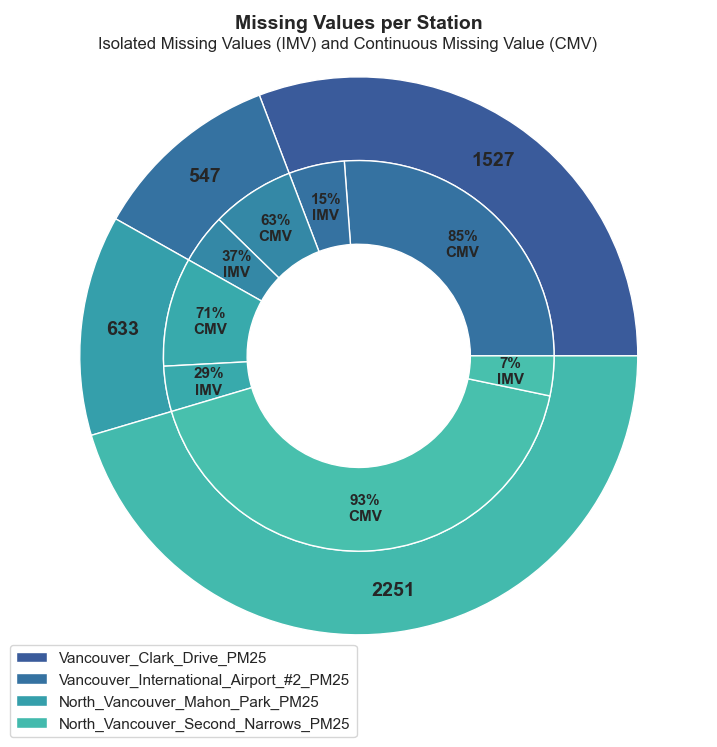

In [14]:
# Continuous Missing Values & Isolated Missing Values count
tot_missing = []
stations_cmv_imv = []
stations_cmv_imv_label = []

# Count of CMV and IMV intervals and percentage out of total missing
for station in stations:
    # Total missing values
    tot_missing_current = datasets[station]['isMissing'].sum()
    tot_missing.append(tot_missing_current)
    # Total Continuous Missing Value
    tot_cmv = metadata[station].loc[metadata[station]['isCMV'] == 1, 'nan_count'].sum()
    stations_cmv_imv.append(tot_cmv)
    stations_cmv_imv_label.append(f"{tot_cmv/tot_missing_current * 100:.0f}%\nCMV")
    # Total Isolated Missing Value
    tot_imv = tot_missing_current - tot_cmv
    stations_cmv_imv.append(tot_imv)
    stations_cmv_imv_label.append(f"{tot_imv/tot_missing_current * 100:.0f}%\nIMV")

# Stacked pie charts with IMV and CMS percentages
fig, ax = plt.subplots(figsize=(9, 9))
ax.axis("equal")
width = 0.3

# Color map
cm = plt.get_cmap("mako")
cout = cm([100, 120, 160, 185])

# Outer pie chart (total missing values per station)
pie, texts1 = ax.pie(
    tot_missing,
    radius=1,
    labels=tot_missing,
    colors=cout,
    labeldistance=0.85,
    textprops={"fontsize": 14, "weight": "bold"},
)
for t in texts1:
    t.set_horizontalalignment("center")
plt.legend(pie, stations, loc=(0, -0.05))
plt.setp(pie, width=width, edgecolor="white")

# Inner pie chart (percentage of IMV and CMV out of total missing)
cin = cm([120, 120, 140, 140, 170, 170, 190, 190])
pie2, texts2 = ax.pie(
    stations_cmv_imv,
    radius=1 - width,
    labels=stations_cmv_imv_label,
    labeldistance=0.78,
    colors=cin,
    textprops={"weight": "bold"},
)
for t in texts2:
    t.set_horizontalalignment("center")
plt.setp(pie2, width=width, edgecolor="white")
plt.title("Missing Values per Station", fontsize=14, weight="bold", y=0.96)
plt.suptitle(
    "Isolated Missing Values (IMV) and Continuous Missing Value (CMV)",
    fontsize=12,
    y=0.85,
)
plt.show()

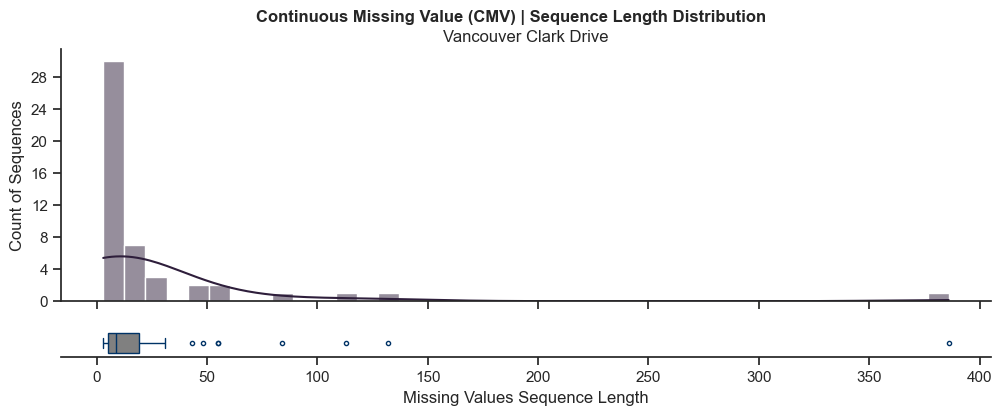

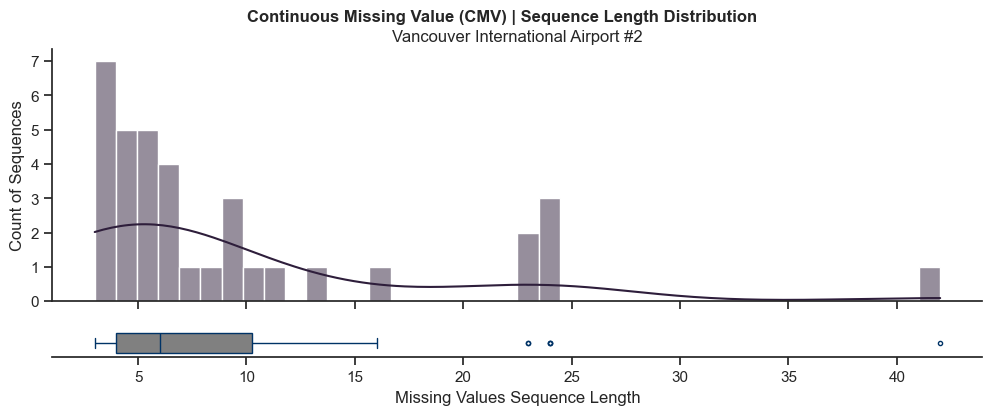

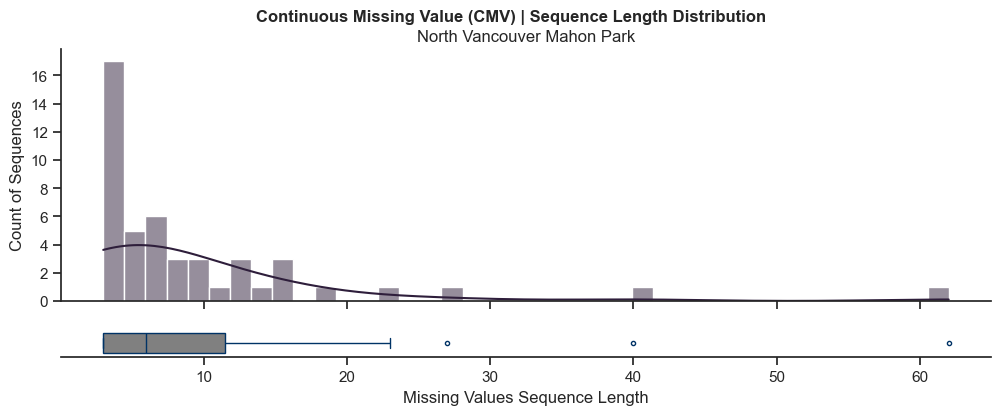

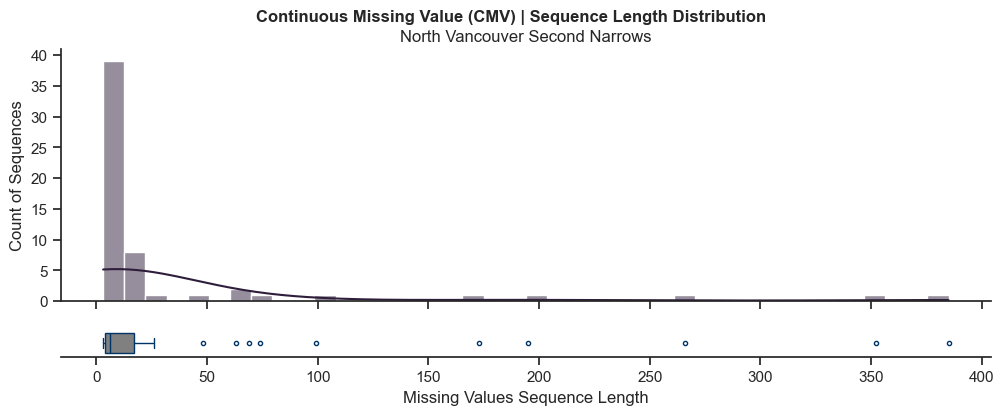

In [15]:
# Distribution of CMV Sequence Length
for station in stations:
    _, (ax_hist, ax_box) = plt.subplots(
        2,
        sharex=True,
        gridspec_kw={"height_ratios": (.9, .10)},
        figsize=(12,4)
    )

    plot_title = station[:-5].replace('_', ' ')
    cmv_counts = metadata[station].loc[metadata[station]['isCMV'] == 1, 'nan_count'].to_list()

    sns.histplot(x=cmv_counts, kde=True, bins=40, ax=ax_hist)
    sns.boxplot(x=cmv_counts, width=0.7, color='0.5', linecolor='#003366', flierprops={'marker': '.'}, ax=ax_box)

    ax_hist.set(title=plot_title, ylabel=f'Count of Sequences')
    ax_hist.yaxis.set_major_locator(MaxNLocator(integer=True))
    plt.suptitle('Continuous Missing Value (CMV) | Sequence Length Distribution',
                 fontweight='bold',
                 fontsize=12)
    ax_box.set(yticks=[], xlabel='Missing Values Sequence Length')
    sns.despine(ax=ax_hist)
    sns.despine(ax=ax_box, left=True)

### Generating Artificial Missing Data
Artificially missing data will be generated to evaluate imputation methods.

In [16]:
%load_ext autoreload
%autoreload 2
from tshelpers.subset import subset_interval, create_missing
from tshelpers.plot import plot_sequence, plot_compare, plot_missing
from tshelpers.metrics import rmse_score, mae_score

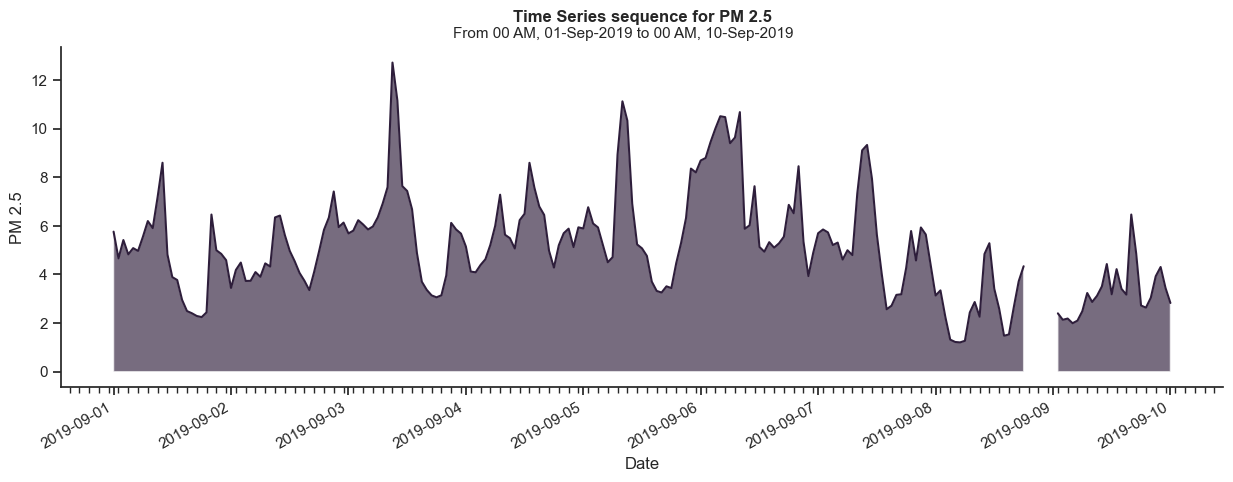

In [17]:
station_subset = master_df[master_df["Station"] == "North_Vancouver_Mahon_Park_PM25"]

subset, subset_missing = create_missing(
    data=station_subset,
    value="PM 2.5",
    start=datetime(2019, 9, 1),
    end=datetime(2019, 9, 10),
    missing_length=6,
    padding=24,
    missing_index="end",
)

plot_sequence(data=subset_missing, value="PM 2.5")

In [18]:
subset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 217 entries, 2019-09-01 00:00:00 to 2019-09-10 00:00:00
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Station     217 non-null    object 
 1   PM 2.5      217 non-null    float64
 2   isMissing   217 non-null    int64  
 3   seqMissing  217 non-null    int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 8.5+ KB


In [19]:
subset_missing.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 217 entries, 2019-09-01 00:00:00 to 2019-09-10 00:00:00
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Station     217 non-null    object 
 1   PM 2.5      211 non-null    float64
 2   isMissing   217 non-null    int64  
 3   seqMissing  217 non-null    int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 8.5+ KB


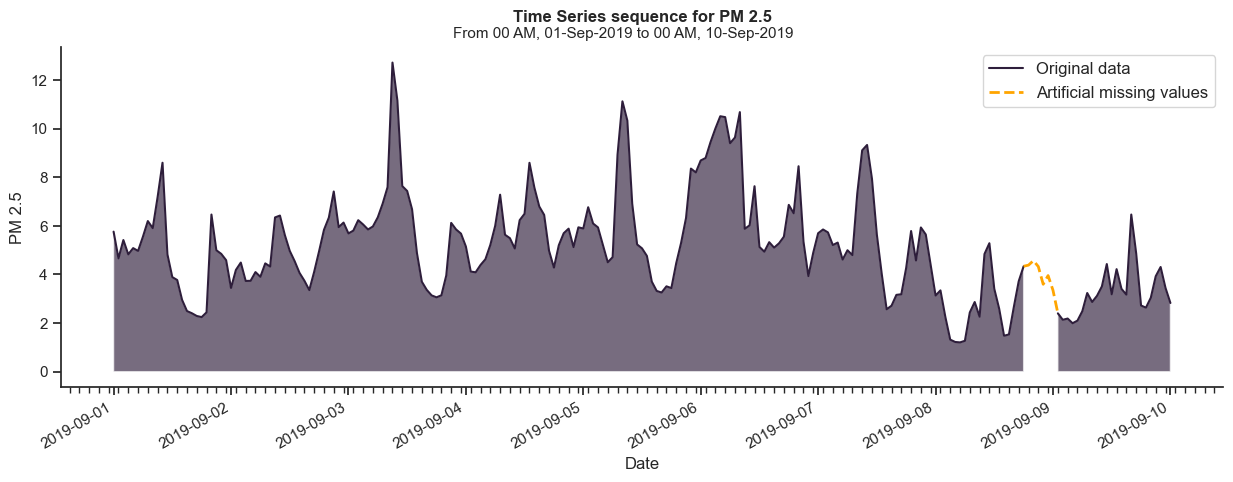

In [20]:
plot_compare(
    data=subset,                            # Subset to plot
    data_missing=subset_missing,            # Subset with missing values to plot
    value="PM 2.5",                         # Variable to plot from subset
    value_missing="PM 2.5",                 # Variable to plot from subset_missing
    missing_only=True,                      # Plt only the section with missing values from subset_missing
    start=datetime(2019, 9, 1),
    end=datetime(2019, 9, 10),
    fill=True,
    data_label="Artificial missing values", # Label for subset
    data_missing_label="Original data",     # Label for subset_missing
)

## Imputation of short sequences [1h, 2h]
* Short sequences with 2 or less subsequent data points missing
* Testing between cubic spline and linear imputation

### Subsetting intervals for experimentation
Defining candidate subsets to experiment with imputation methods.

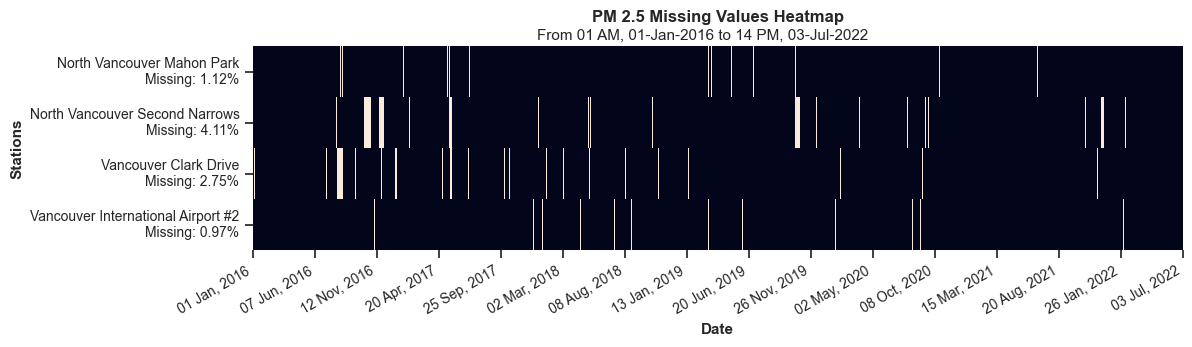

In [21]:
plot_missing(master_df.pivot(columns="Station", values="PM 2.5"))

In [22]:
# Looking for months without missing values
months_complete = {}
for station in stations:
    months_complete[station] = []
    station_subset = master_df[master_df["Station"] == station]
    for year in range (2016, 2022):
        if year == 2022:
            range_max = 7 # Limiting upper range for 2022 as data goes up to July
        else:
            range_max = 13
        for month in range(1, range_max):
            if month == 12:
                subset = station_subset[datetime(year, month, 1, 1): datetime(year, month, 31, 23)]
            else:
                subset = station_subset[datetime(year, month, 1, 1): datetime(year, month+1, 1)]
            if subset['PM 2.5'].isna().sum() == 0:
                months_complete[station].append((month, year))

for station in months_complete:
    print(f"{station} has {len(months_complete[station])} complete months:\n{months_complete[station]}\n")

Vancouver_Clark_Drive_PM25 has 3 complete months:
[(4, 2016), (10, 2016), (2, 2019)]

Vancouver_International_Airport_#2_PM25 has 3 complete months:
[(4, 2016), (7, 2016), (4, 2019)]

North_Vancouver_Mahon_Park_PM25 has 5 complete months:
[(1, 2016), (4, 2016), (6, 2016), (6, 2017), (2, 2018)]

North_Vancouver_Second_Narrows_PM25 has 9 complete months:
[(2, 2016), (6, 2016), (7, 2016), (3, 2017), (4, 2017), (9, 2017), (2, 2019), (4, 2019), (6, 2019)]



In [23]:
# Experimental subsets
exp_subsets = {}

for station in months_complete:
    exp_subsets[station] = {}
    for months in months_complete[station]: # Iterating on list of tuples (month, year) | (4, 2016)
        month = months[0]
        year = months[1]
        if month == 12:
            next_month = 1
            next_year = year+1
        else:
            next_month = month+1
            next_year = year
        exp_subsets[station][f'{month}-{year}'] = master_df[master_df["Station"] == station][
            datetime(year, month, 1):datetime(next_year, next_month, 1)
        ]

In [24]:
for station in exp_subsets:
    print(f'{station}:\n {exp_subsets[station].keys()}\n')

Vancouver_Clark_Drive_PM25:
 dict_keys(['4-2016', '10-2016', '2-2019'])

Vancouver_International_Airport_#2_PM25:
 dict_keys(['4-2016', '7-2016', '4-2019'])

North_Vancouver_Mahon_Park_PM25:
 dict_keys(['1-2016', '4-2016', '6-2016', '6-2017', '2-2018'])

North_Vancouver_Second_Narrows_PM25:
 dict_keys(['2-2016', '6-2016', '7-2016', '3-2017', '4-2017', '9-2017', '2-2019', '4-2019', '6-2019'])



In [25]:
exp_subsets['North_Vancouver_Mahon_Park_PM25']['1-2016'].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 744 entries, 2016-01-01 01:00:00 to 2016-02-01 00:00:00
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Station     744 non-null    object 
 1   PM 2.5      744 non-null    float64
 2   isMissing   744 non-null    int64  
 3   seqMissing  744 non-null    int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 29.1+ KB


### Experimentation method
Backwards missing value generation.

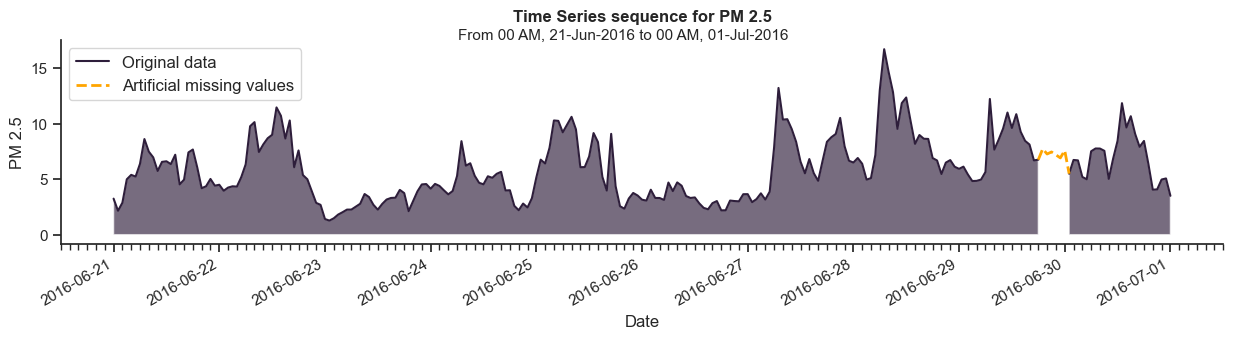

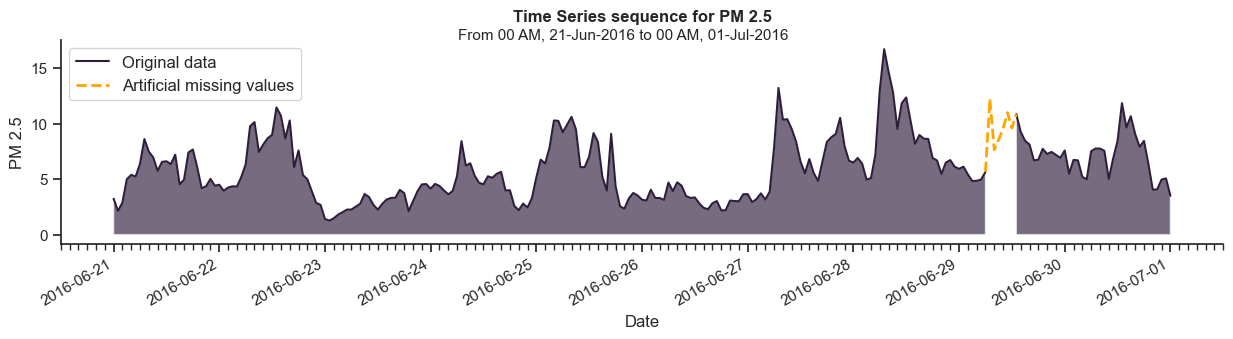

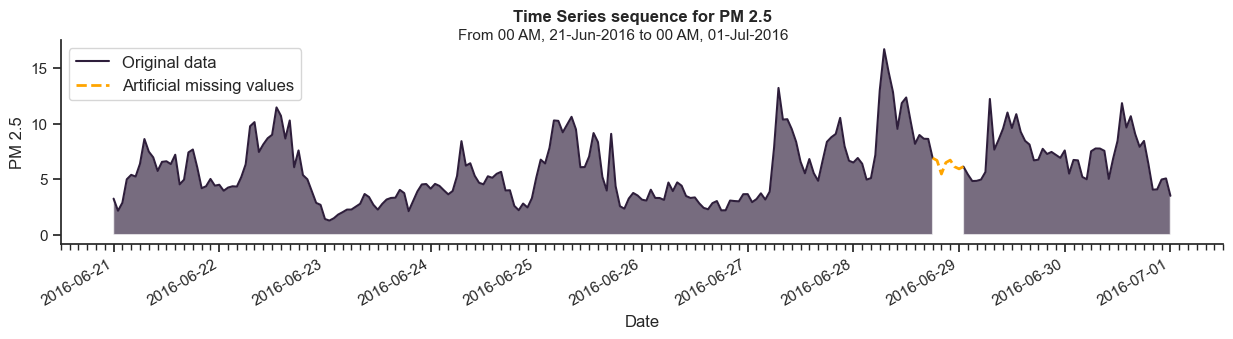

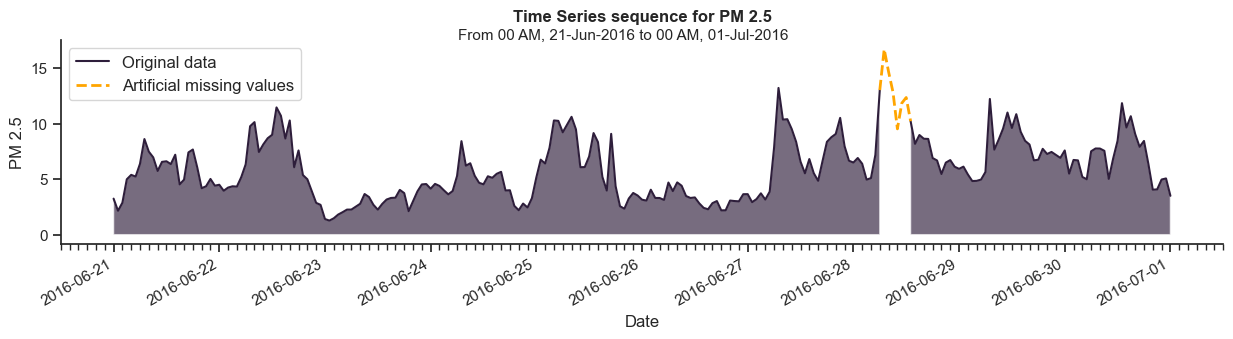

In [26]:
# Implementation example iterating through different paddings
paddings = [24, 36, 48, 60]

for padding in paddings:
    subset, subset_missing = create_missing(
        data=station_subset,
        value="PM 2.5",
        start=datetime(2016, 6, 21),
        end=datetime(2016, 7, 1),
        missing_length=6,
        padding=padding,
        missing_index="end",
    )
    plot_compare(
        subset,
        subset_missing,
        value="PM 2.5",
        value_missing="PM 2.5",
        missing_only=True,
        data_label="Artificial missing values",
        data_missing_label="Original data",
        figsize=(15, 3)
    )

Imputation example with linear interpolation

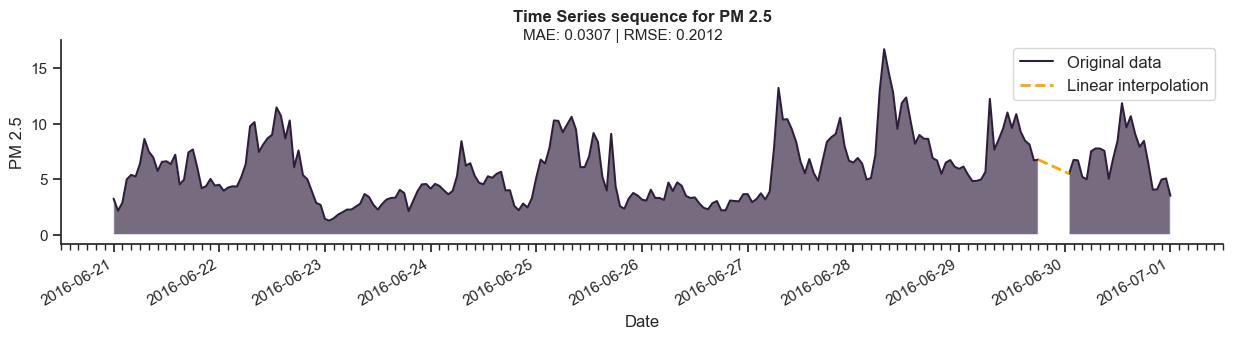

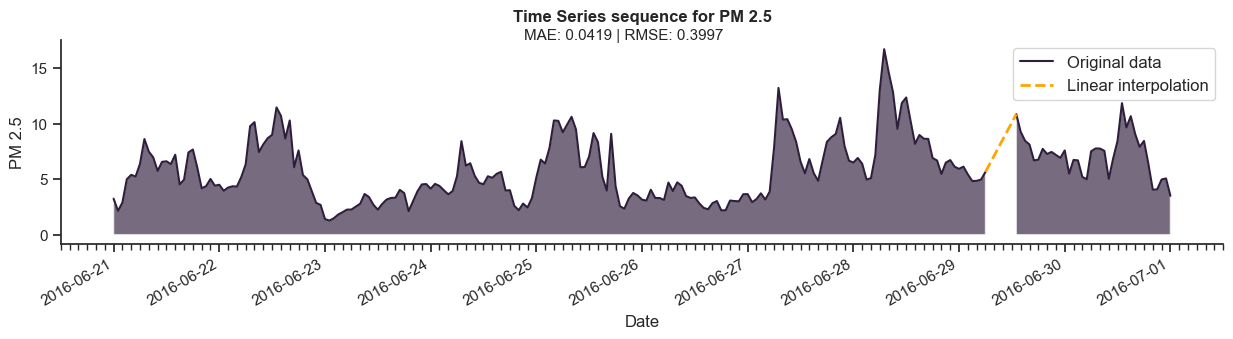

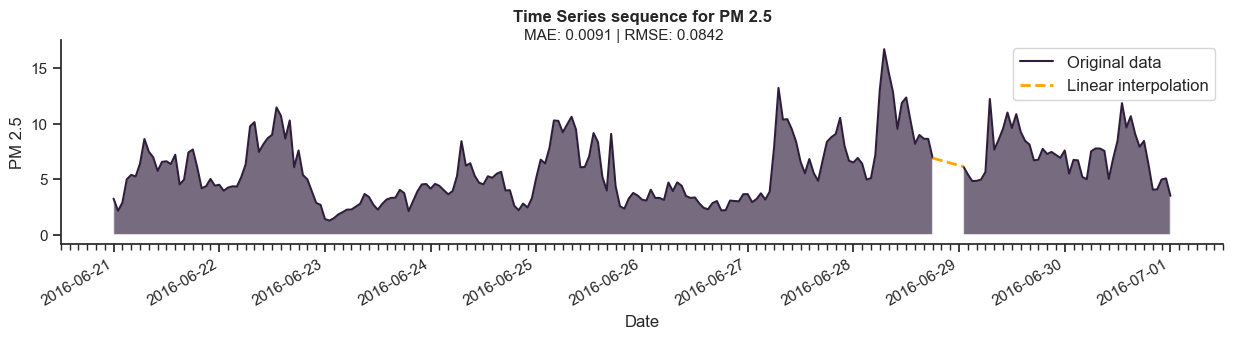

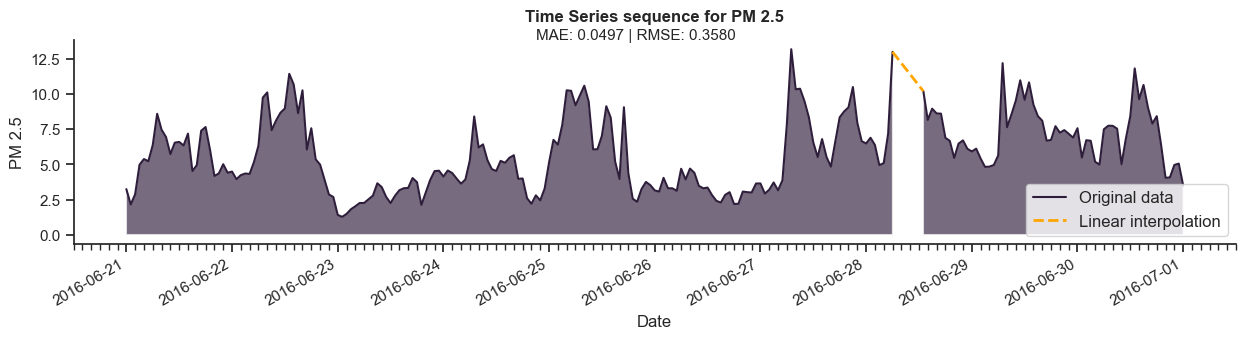

In [27]:
# Implementation example with linear interpolation:
for padding in paddings:
    subset, subset_missing = create_missing(
        data=station_subset,
        value="PM 2.5",
        start=datetime(2016, 6, 21),
        end=datetime(2016, 7, 1),
        missing_length=6,
        padding=padding,
        missing_index="end",
    )

    subset_linear = subset.copy()
    subset_linear["PM 2.5"] = (
        subset_missing["PM 2.5"].interpolate(method="linear").tolist()
    )
    
    plot_compare(
        subset_linear,
        subset_missing,
        value="PM 2.5",
        value_missing="PM 2.5",
        missing_only=True,
        data_label="Linear interpolation",
        data_missing_label="Original data",
        plot_sup_title=f"MAE: {mae_score(subset, subset_linear, value='PM 2.5', verbose=False):.4f}\
 | RMSE: {rmse_score(subset, subset_linear, value='PM 2.5', verbose=False):.4f}",
        figsize=(15, 3)
    )

Imputation example with cubic spline

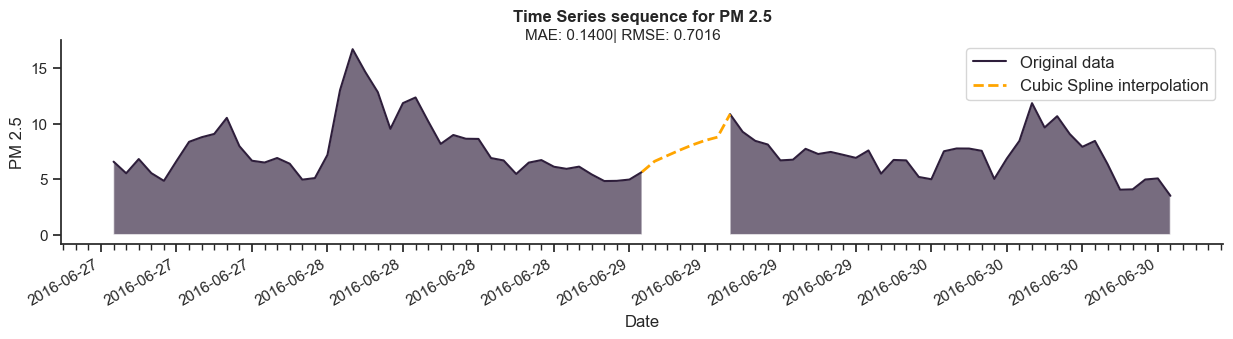

In [28]:
# Cubic spline interpolation - Pandas Series.interpolate
subset, subset_missing = create_missing(
    data=station_subset,
    value='PM 2.5',
    start=datetime(2016, 6, 27, 12),
    end=datetime(2016, 7, 1),
    missing_length=6,
    padding=36, #24, 36, 48, 60
    missing_index='end',
)

subset_spline = subset.copy()
subset_spline["PM 2.5"] = (
    subset_missing["PM 2.5"].interpolate(method="spline", order=3).tolist()
)

plot_compare(
    subset_spline,
    subset_missing,
    value="PM 2.5",
    value_missing="PM 2.5",
    missing_only=True,
    data_label="Cubic Spline interpolation",
    data_missing_label="Original data",
    plot_sup_title=f"MAE: {mae_score(subset, subset_spline, value='PM 2.5', verbose=False):.4f}\
| RMSE: {rmse_score(subset, subset_spline, value='PM 2.5', verbose=False):.4f}",
    figsize=(15, 3)
)

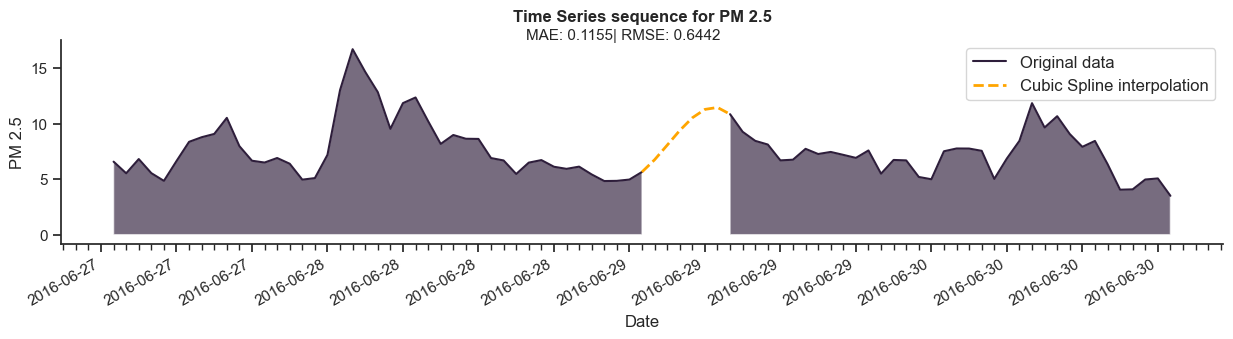

In [29]:
# Cubic spline interpolation - Scipy interpolate.splrep
pd.options.mode.chained_assignment = None # Shutdown warnings when working on slices of dataframes
from scipy import interpolate

subset, subset_missing = create_missing(
    data=station_subset,
    value='PM 2.5',
    start=datetime(2016, 6, 27, 12),
    end=datetime(2016, 7, 1),
    missing_length=6,
    padding=36, #24, 36, 48, 60
    missing_index='end',
)

subset_spline = subset.copy()
# Indexing missing values
missing_idx = np.where(subset_missing["PM 2.5"].isna())[0].tolist()

# Indexing boundary values at t-2, t-1, t+1, and t+2
boundary_idx = []
for idx in range(min(missing_idx)-2, max(missing_idx)+3):
    if idx not in missing_idx:
        boundary_idx.append(idx)
boundary = subset_missing["PM 2.5"][boundary_idx].tolist()

# Fitting cubic spline
cubic_spline = interpolate.splrep(x=boundary_idx, y=boundary, k=3)
imputed = interpolate.splev(missing_idx, cubic_spline)

subset_spline["PM 2.5"][missing_idx] = imputed

plot_compare(
    subset_spline,
    subset_missing,
    value="PM 2.5",
    value_missing="PM 2.5",
    missing_only=True,
    data_label="Cubic Spline interpolation",
    data_missing_label="Original data",
    plot_sup_title=f"MAE: {mae_score(subset, subset_spline, value='PM 2.5', verbose=False):.4f}\
| RMSE: {rmse_score(subset, subset_spline, value='PM 2.5', verbose=False):.4f}",
    figsize=(15, 3)
)

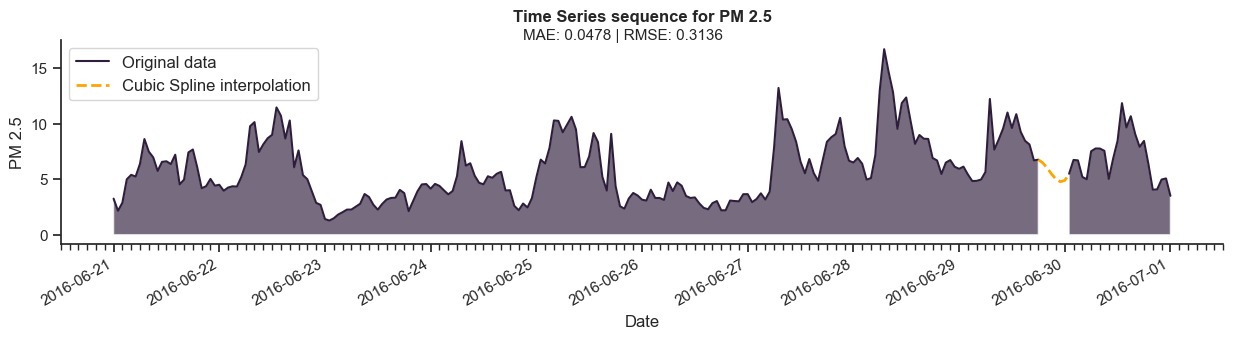

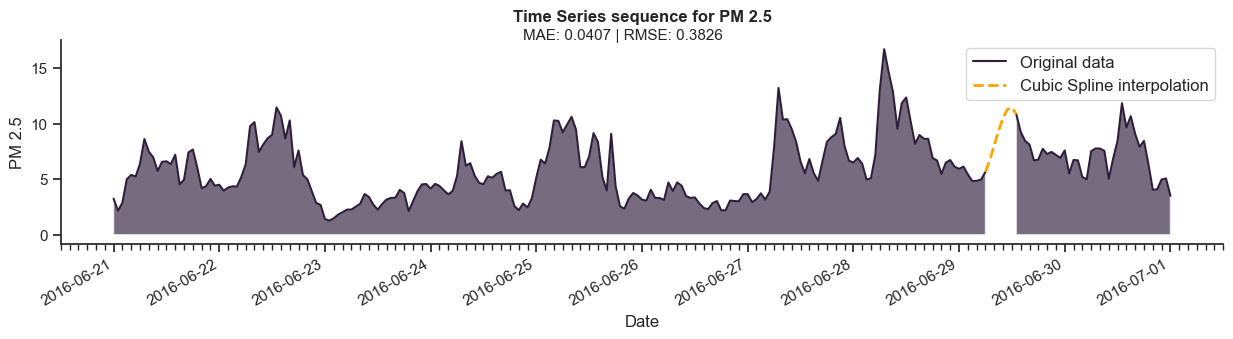

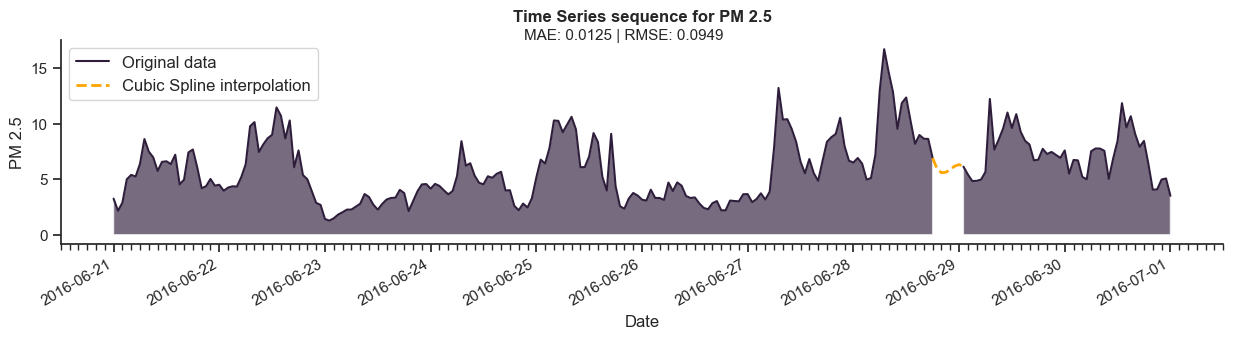

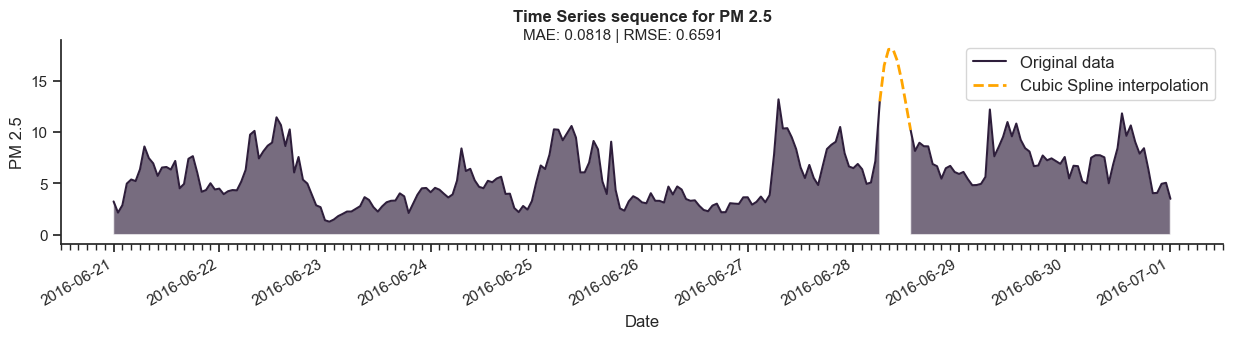

In [30]:
# Implementation example with cubic spline interpolation
for padding in paddings:
    subset, subset_missing = create_missing(
        data=station_subset,
        value="PM 2.5",
        start=datetime(2016, 6, 21),
        end=datetime(2016, 7, 1),
        missing_length=6,
        padding=padding,
        missing_index="end",
    )

    subset_spline = subset.copy()
    # Indexing missing values
    missing_idx = np.where(subset_missing["PM 2.5"].isna())[0].tolist()

    # Indexing boundary values at t-2, t-1, t+1, and t+2
    boundary_idx = []
    for idx in range(min(missing_idx)-2, max(missing_idx)+3):
        if idx not in missing_idx:
            boundary_idx.append(idx)
    boundary = subset_missing["PM 2.5"][boundary_idx].tolist()

    # Fitting cubic spline
    cubic_spline = interpolate.splrep(x=boundary_idx, y=boundary, k=3)
    imputed = interpolate.splev(missing_idx, cubic_spline)

    subset_spline["PM 2.5"][missing_idx] = imputed

    plot_compare(
        subset_spline,
        subset_missing,
        value="PM 2.5",
        value_missing="PM 2.5",
        missing_only=True,
        data_label="Cubic Spline interpolation",
        data_missing_label="Original data",
        plot_sup_title=f"MAE: {mae_score(subset, subset_spline, value='PM 2.5', verbose=False):.4f}\
 | RMSE: {rmse_score(subset, subset_spline, value='PM 2.5', verbose=False):.4f}",
        figsize=(15, 3)
    )

>Ref.: _Carl de Boor, “A Practical Guide to Splines”, Springer-Verlag, 1978. pp 40-50_

### Linear and Cubic Spline imputation of Short Sequences
* Iteration through missing lengths ∈ (1h, 2h)
* For each subset, generate missing lengths on every hour, from right to left
* Measure Root-Mean-Square Error (RMSE) and Mean-Absolute Error (MAE) against original data

In [31]:
%%time
# Iterate through stations, then subsets to evaluate linear interpolation vs. cubic spline
from tqdm import tqdm

# Artificial missing values function parameters
create_missing_args = {
    "value": "PM 2.5",
    "missing_index": "end"
}

imputation_results = {}
for station in (pbar := tqdm(exp_subsets)):
    pbar.set_description(f"Processing station {station}")
    for station_subset in exp_subsets[station]:
        imputation_step = str(station + "_" + station_subset)
        imputation_results[imputation_step] = {}
        imputation_results[imputation_step]["RMSE_Cubic"] = []
        imputation_results[imputation_step]["RMSE_Linear"] = []
        imputation_results[imputation_step]["MAE_Cubic"] = []
        imputation_results[imputation_step]["MAE_Linear"] = []
        imputation_results[imputation_step]["Missing_Length"] = []        
        # Generating backwards missing intervals
        paddings = [i for i in range(2, len(exp_subsets[station][station_subset]))]
        for padding in paddings:
            # Creating missing interval with length = 1 and length = 2
            for length in [1, 2]:
                subset, subset_missing = create_missing(
                    **create_missing_args,
                    data=exp_subsets[station][station_subset],
                    padding=padding,
                    missing_length=length
                )
                ### Cubic spline
                subset_spline = subset.copy()
                missing_idx = np.where(subset_missing["PM 2.5"].isna())[0].tolist()

                # Indexing boundary values at t-2, t-1, t+1, and t+2
                boundary_idx = []
                for idx in range(min(missing_idx)-2, max(missing_idx)+3):
                    if idx not in missing_idx:
                        boundary_idx.append(idx)
                boundary = subset_missing["PM 2.5"][boundary_idx].tolist()

                # Fitting cubic spline
                cubic_spline = interpolate.splrep(x=boundary_idx, y=boundary, k=3)
                imputed = interpolate.splev(missing_idx, cubic_spline)
                subset_spline["PM 2.5"][missing_idx] = imputed

                # Evaluating cubic spline
                rmse_cubic = rmse_score(subset, subset_spline, value="PM 2.5", verbose=False)
                mae_cubic = mae_score(subset, subset_spline, value="PM 2.5", verbose=False)
                imputation_results[imputation_step]["RMSE_Cubic"].append(rmse_cubic)
                imputation_results[imputation_step]["MAE_Cubic"].append(mae_cubic)

                ### Linear interpolation
                subset_linear = subset.copy()
                subset_linear["PM 2.5"] = subset_missing["PM 2.5"].interpolate(method="linear", inplace=False).tolist()

                # Evaluating linear interpolation
                rmse_linear = rmse_score(subset, subset_linear, value="PM 2.5", verbose=False)
                mae_linear = mae_score(subset, subset_linear, value="PM 2.5", verbose=False)
                imputation_results[imputation_step]["RMSE_Linear"].append(rmse_linear)
                imputation_results[imputation_step]["MAE_Linear"].append(mae_linear)
                imputation_results[imputation_step]["Missing_Length"].append(length)

Processing station North_Vancouver_Second_Narrows_PM25: 100%|██████████| 4/4 [01:10<00:00, 17.74s/it]    

CPU times: user 1min 10s, sys: 49.9 ms, total: 1min 10s
Wall time: 1min 11s


In [32]:
# Concatenating master dataframe
subsets = []
for subset in imputation_results.keys():
    subsets.append(pd.DataFrame(imputation_results[subset]))

metrics_df = pd.concat(subsets).reset_index(drop=True)
metrics_df.round(6).head()

,RMSE_Cubic,RMSE_Linear,MAE_Cubic,MAE_Linear,Missing_Length
0,0.033493,0.024058,0.001247,0.000896,1
1,0.050441,0.051899,0.001883,0.002001,2
2,0.050351,0.050928,0.001875,0.001897,1
3,0.059907,0.051147,0.002644,0.001921,2
4,0.026684,0.025138,0.000994,0.000936,1


### RMSE and MAE results

In [33]:
metrics_df.groupby("Missing_Length").describe(percentiles=[]).T.round(5)

Missing_Length               1            2
RMSE_Cubic  count  14331.00000  14331.00000
            mean       0.03324      0.06474
            std        0.04989      0.08141
            min        0.00001      0.00024
            50%        0.01754      0.03899
            max        0.80107      1.29857
RMSE_Linear count  14331.00000  14331.00000
            mean       0.03193      0.05956
            std        0.04772      0.07408
            min        0.00000      0.00000
            50%        0.01698      0.03662
            max        0.78733      1.38782
MAE_Cubic   count  14331.00000  14331.00000
            mean       0.00124      0.00314
            std        0.00187      0.00399
            min        0.00000      0.00001
            50%        0.00065      0.00186
            max        0.03088      0.06828
MAE_Linear  count  14331.00000  14331.00000
            mean       0.00119      0.00288
            std        0.00178      0.00359
            min        0.00000      0.00000
            50%        0.00063      0.00176
            max        0.03002      0.07297

In [34]:
# Melting dataframes for boxplot visualizations
RMSE_melt_df = pd.melt(metrics_df[["RMSE_Cubic", "RMSE_Linear", "Missing_Length"]].rename(columns=lambda x: x.split("_")[1]),
                      id_vars="Length",
                      var_name="Method",
                      value_name="RMSE")

MAE_melt_df = pd.melt(metrics_df[["MAE_Cubic", "MAE_Linear", "Missing_Length"]].rename(columns=lambda x: x.split("_")[1]),
                      id_vars="Length",
                      var_name="Method",
                      value_name="MAE")

display(RMSE_melt_df.head())
print(RMSE_melt_df.shape)
display(MAE_melt_df.head())
print(MAE_melt_df.shape)

,Length,Method,RMSE
0,1,Cubic,0.033493
1,2,Cubic,0.050441
2,1,Cubic,0.050351
3,2,Cubic,0.059907
4,1,Cubic,0.026684


(57324, 3)


,Length,Method,MAE
0,1,Cubic,0.001247
1,2,Cubic,0.001883
2,1,Cubic,0.001875
3,2,Cubic,0.002644
4,1,Cubic,0.000994


(57324, 3)


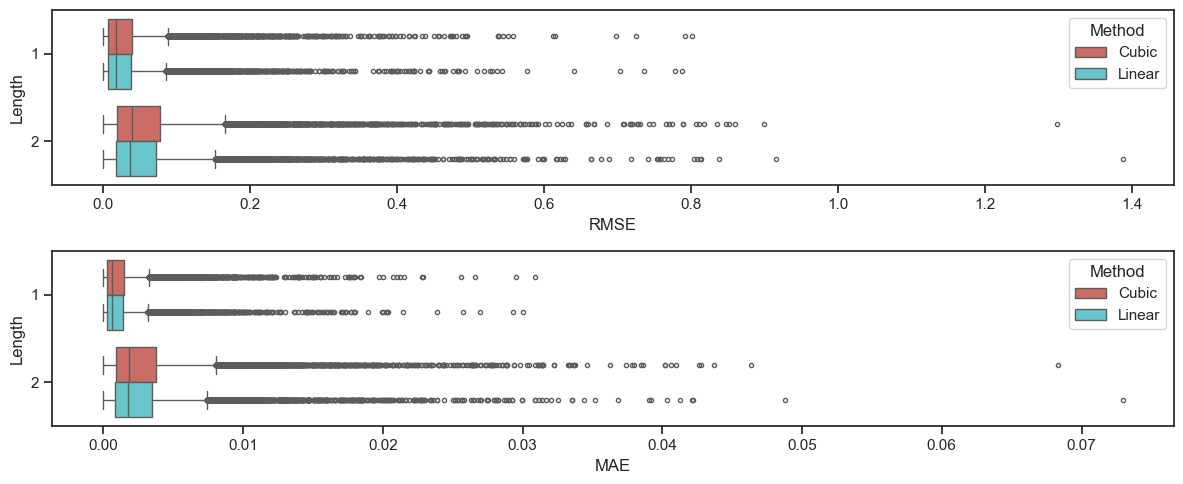

In [35]:
# Boxplot of metrics results
fig, axs = plt.subplots(2, 1, figsize=(12, 5))
box_plot_args = {
    "y": "Length",
    "hue": "Method",
    "palette": "hls",
    "orient": "h",
    "flierprops": {'marker': '.'}
}
sns.boxplot(RMSE_melt_df,
            x="RMSE",
            ax=axs[0],
            **box_plot_args)
sns.boxplot(MAE_melt_df,
            x="MAE",
            ax=axs[1],
            **box_plot_args)
fig.tight_layout()
plt.show()

RMSE metrics without outliers: (56139, 3). Outliers removed: 1185.
MAE metrics without outliers: (56148, 3). Outliers removed: 1176.


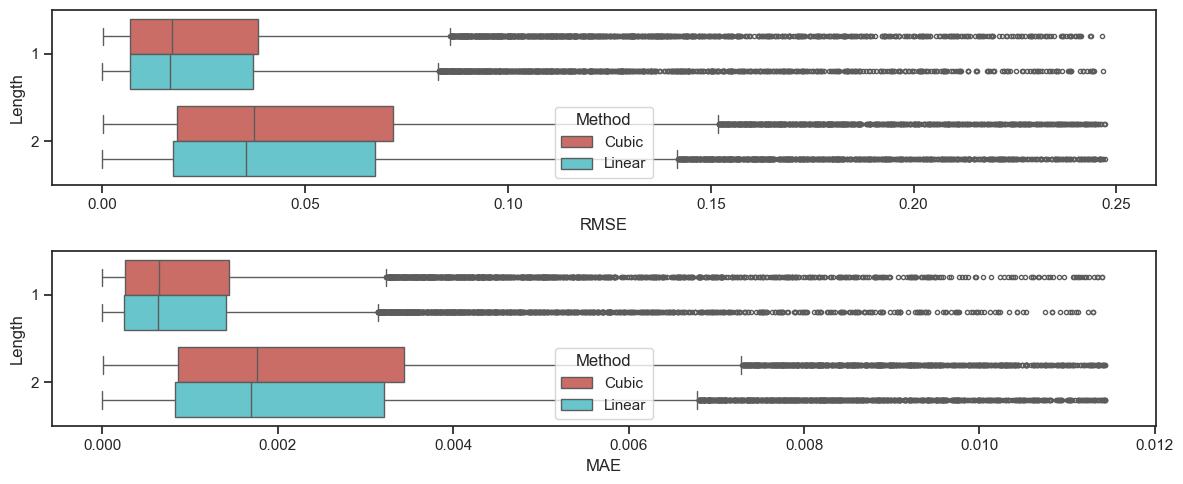

In [36]:
# Metrics without outliers
RMSE_melt_df_noout = RMSE_melt_df[(np.abs(stats.zscore(RMSE_melt_df["RMSE"])) < 3)]
MAE_melt_df_noout = MAE_melt_df[(np.abs(stats.zscore(MAE_melt_df["MAE"])) < 3)]
print(f"RMSE metrics without outliers: {RMSE_melt_df_noout.shape}.\
 Outliers removed: {MAE_melt_df.shape[0] - RMSE_melt_df_noout.shape[0]}.")
print(f"MAE metrics without outliers: {MAE_melt_df_noout.shape}.\
 Outliers removed: {MAE_melt_df.shape[0] - MAE_melt_df_noout.shape[0]}.")

# Boxplot of metrics results without outliers
fig, axs = plt.subplots(2, 1, figsize=(12, 5))
sns.boxplot(RMSE_melt_df_noout,
            x="RMSE",
            ax=axs[0],
            **box_plot_args)
sns.boxplot(MAE_melt_df_noout,
            x="MAE",
            ax=axs[1],
            **box_plot_args)
fig.tight_layout()
plt.show()

### Imputing short sequences [1h, 2h]
* Imputation of short sequences up to 2h with linear method

,Missing,Missing %
Station,0,0.00
PM 2.5,4958,2.22
isMissing,0,0.00
seqMissing,0,0.00


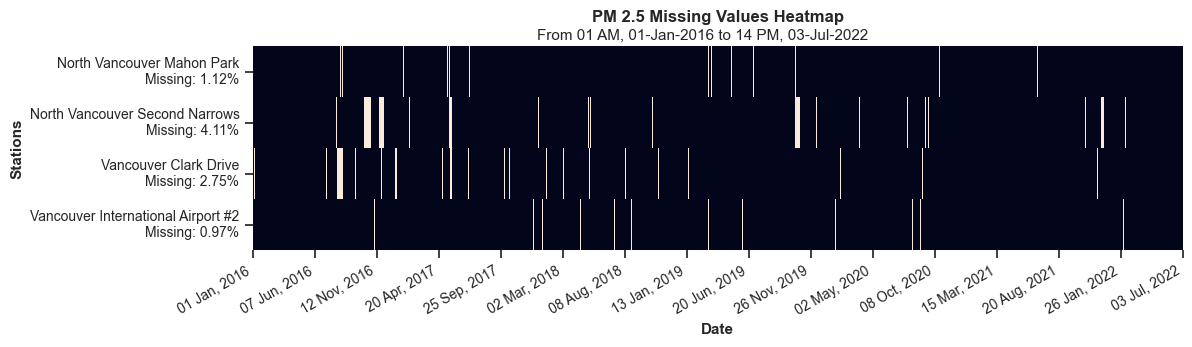

In [37]:
# Missing summary before linear interpolation imputation
missing_tot = master_df.isna().sum()
missing_pct = round(master_df.isna().sum()/master_df.count()*100, 2)
missing_summary = pd.concat([missing_tot, missing_pct], axis=1)
missing_summary.rename(columns={0: 'Missing', 1: 'Missing %'}, inplace=True)
display(missing_summary)

plot_missing(master_df.pivot(columns="Station", values="PM 2.5"))

,Missing,Missing %
Station,0,0.00
PM 2.5,4175,1.86
isMissing,0,0.00
seqMissing,0,0.00


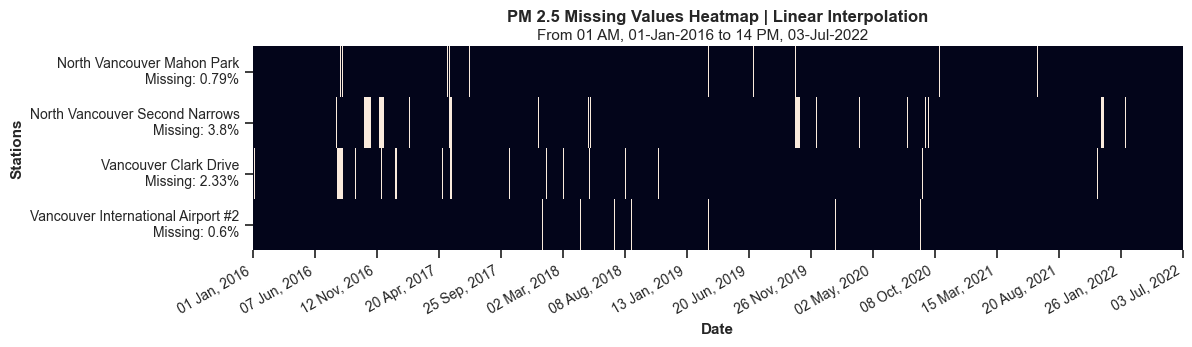

In [38]:
# Linear interpolation imputation
master_df.loc[master_df["seqMissing"] <= 2, "PM 2.5"] = master_df.loc[master_df["seqMissing"] <= 2, "PM 2.5"].interpolate()

# Missing summary
missing_tot = master_df.isna().sum()
missing_pct = round(master_df.isna().sum()/master_df.count()*100, 2)
missing_summary = pd.concat([missing_tot, missing_pct], axis=1)
missing_summary.rename(columns={0: 'Missing', 1: 'Missing %'}, inplace=True)
display(missing_summary)

plot_missing(master_df.pivot(columns="Station", values="PM 2.5"), plot_title="PM 2.5 Missing Values Heatmap | Linear Interpolation")

In [39]:
# Flag for interpolated values
master_df['isImputedInterpolation'] = 0
master_df.loc[(master_df['isMissing'] == 1) & (~master_df['PM 2.5'].isna()), 'isImputedInterpolation'] = 1

master_df[master_df['seqMissing'].isin([1, 2])]

,Station,PM 2.5,isMissing,seqMissing,isImputedInterpolation
DATE_PST,,,,,
2016-01-05 09:00:00,Vancouver_Clark_Drive_PM25,6.407333,1,2,1
2016-01-05 10:00:00,Vancouver_Clark_Drive_PM25,6.528667,1,2,1
2016-01-06 10:00:00,Vancouver_Clark_Drive_PM25,14.106667,1,2,1
2016-01-06 11:00:00,Vancouver_Clark_Drive_PM25,16.090333,1,2,1
2016-02-02 14:00:00,Vancouver_Clark_Drive_PM25,5.272000,1,2,1
...,...,...,...,...,...
2022-04-27 08:00:00,North_Vancouver_Second_Narrows_PM25,9.099740,1,1,1
2022-05-10 08:00:00,North_Vancouver_Second_Narrows_PM25,4.874899,1,1,1
2022-05-24 07:00:00,North_Vancouver_Second_Narrows_PM25,5.961384,1,1,1


In [40]:
for station in stations:
    station_subset = master_df.loc[master_df["Station"] == station, ["PM 2.5"]]
    station_subset.reset_index(inplace=True)

    original_metadata = metadata[station]
    metadata[station] = {}
    metadata[station]['original'] = original_metadata
    metadata[station]['imputedIMV'] = count_sequences(station_subset, time='DATE_PST', value='PM 2.5')

In [41]:
metadata['North_Vancouver_Mahon_Park_PM25']['original']

,seq_start_idx,seq_end_idx,seq_start_time,seq_end_time,not_nan_count,nan_count,isCMV,isIMV
0,0,830,2016-01-01 01:00:00,2016-02-04 15:00:00,831,0,0,0
1,831,831,2016-02-04 16:00:00,2016-02-04 16:00:00,0,1,0,1
2,832,1140,2016-02-04 17:00:00,2016-02-17 13:00:00,309,0,0,0
3,1141,1141,2016-02-17 14:00:00,2016-02-17 14:00:00,0,1,0,1
4,1142,1977,2016-02-17 15:00:00,2016-03-23 10:00:00,836,0,0,0
...,...,...,...,...,...,...,...,...
394,56219,56411,2022-05-31 12:00:00,2022-06-08 12:00:00,193,0,0,0
395,56412,56412,2022-06-08 13:00:00,2022-06-08 13:00:00,0,1,0,1
396,56413,56742,2022-06-08 14:00:00,2022-06-22 07:00:00,330,0,0,0
397,56743,56743,2022-06-22 08:00:00,2022-06-22 08:00:00,0,1,0,1


In [42]:
metadata['North_Vancouver_Mahon_Park_PM25']['imputedIMV']

,seq_start_idx,seq_end_idx,seq_start_time,seq_end_time,not_nan_count,nan_count
0,0,1977,2016-01-01 01:00:00,2016-03-23 10:00:00,1978,0
1,1978,1991,2016-03-23 11:00:00,2016-03-24 00:00:00,0,14
2,1992,4977,2016-03-24 01:00:00,2016-07-26 10:00:00,2986,0
3,4978,4990,2016-07-26 11:00:00,2016-07-26 23:00:00,0,13
4,4991,5311,2016-07-27 00:00:00,2016-08-09 08:00:00,321,0
...,...,...,...,...,...,...
90,51175,55711,2021-11-02 08:00:00,2022-05-10 08:00:00,4537,0
91,55712,55714,2022-05-10 09:00:00,2022-05-10 11:00:00,0,3
92,55715,56215,2022-05-10 12:00:00,2022-05-31 08:00:00,501,0
93,56216,56218,2022-05-31 09:00:00,2022-05-31 11:00:00,0,3


## Imputation of long sequences (>= 2h)
- MICE univariate
- MICE multivariate

In [43]:
# Candidate subsets to evaluate imputation method
for station in stations:
    print(f'{station}:')
    display(metadata[station]['imputedIMV'].sort_values('not_nan_count', ascending=False).head(3))

Vancouver_Clark_Drive_PM25:


,seq_start_idx,seq_end_idx,seq_start_time,seq_end_time,not_nan_count,nan_count
74,31556,41063,2019-08-07 21:00:00,2020-09-07 00:00:00,9508,0
90,47749,51792,2021-06-12 14:00:00,2021-11-28 01:00:00,4044,0
76,41095,45021,2020-09-08 08:00:00,2021-02-18 22:00:00,3927,0


Vancouver_International_Airport_#2_PM25:


,seq_start_idx,seq_end_idx,seq_start_time,seq_end_time,not_nan_count,nan_count
48,35841,40926,2020-02-02 10:00:00,2020-09-01 07:00:00,5086,0
68,47749,51900,2021-06-12 14:00:00,2021-12-02 13:00:00,4152,0
16,12757,16807,2017-06-15 14:00:00,2017-12-01 08:00:00,4051,0


North_Vancouver_Mahon_Park_PM25:


,seq_start_idx,seq_end_idx,seq_start_time,seq_end_time,not_nan_count,nan_count
26,14924,21292,2017-09-13 21:00:00,2018-06-06 05:00:00,6369,0
90,51175,55711,2021-11-02 08:00:00,2022-05-10 08:00:00,4537,0
70,37628,42104,2020-04-16 21:00:00,2020-10-20 09:00:00,4477,0


North_Vancouver_Second_Narrows_PM25:


,seq_start_idx,seq_end_idx,seq_start_time,seq_end_time,not_nan_count,nan_count
24,13881,17511,2017-08-01 10:00:00,2017-12-30 16:00:00,3631,0
2,1760,5119,2016-03-14 09:00:00,2016-08-01 08:00:00,3360,0
108,48898,52020,2021-07-30 11:00:00,2021-12-07 13:00:00,3123,0


In [44]:
from darts import TimeSeries
from darts.models import LinearRegressionModel
from darts.metrics import mae, rmse

In [45]:
# Auxiliar plotting function
def dart_plot(train, val, plot_title="Time Series Train/Validation Sets", pred=None, pred_label="predicted"):
    plt.figure(figsize=(12, 2.5))
    train.plot(label="training")
    val.plot(label="validation", linewidth=1, color="darkblue")
    if pred:
        pred.plot(label=pred_label, linewidth=1.5, color = "darkorange")
        plt.title(f"MAE: {mae(pred, val):.3f} | RMSE: {rmse(pred, val):.3f}", fontsize=10)
        plt.suptitle(plot_title, fontweight="bold", fontsize=11, y=1.04)
    else:
        plt.title(plot_title, fontweight="bold", fontsize=11)
    plt.legend()
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.ylabel("PM 2.5", fontsize=11)
    plt.xlabel("")
    sns.despine()
    plt.show()

In [46]:
exp_subset = master_df[master_df['Station'] == 'Vancouver_Clark_Drive_PM25']
exp_subset = exp_subset.loc[
    datetime(2019, 8, 8):datetime(2020, 9, 6),
    ['PM 2.5']
]
exp_subset

,PM 2.5
DATE_PST,
2019-08-08 00:00:00,9.478311
2019-08-08 01:00:00,8.098203
2019-08-08 02:00:00,7.140555
2019-08-08 03:00:00,6.998111
2019-08-08 04:00:00,6.678083
...,...
2020-09-05 20:00:00,10.097470
2020-09-05 21:00:00,12.208170
2020-09-05 22:00:00,9.601055


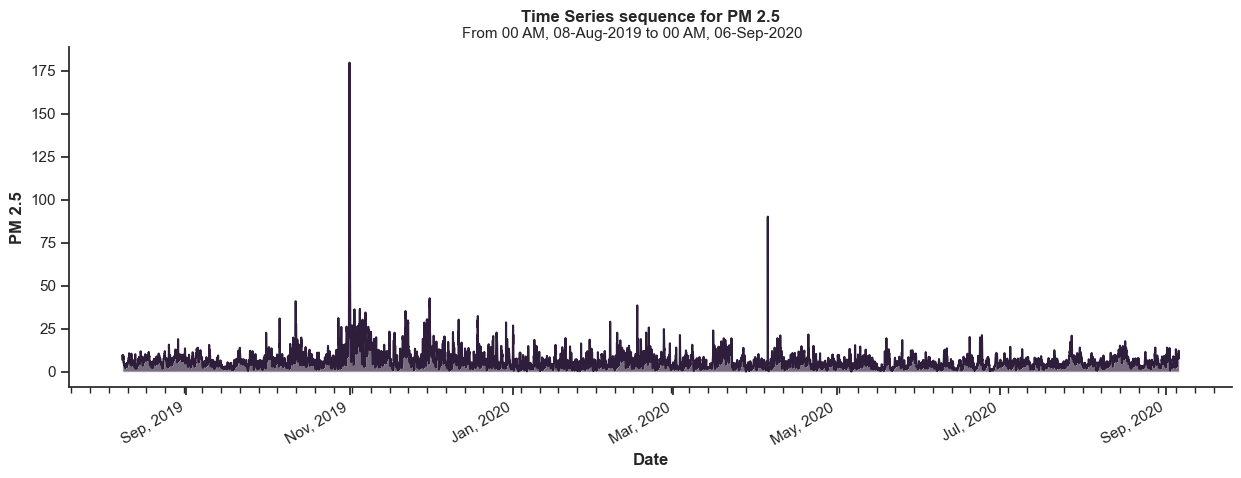

In [47]:
plot_sequence(exp_subset,
              value='PM 2.5')

In [48]:
exp_covariate = master_df.loc[master_df['Station'] != 'Vancouver_Clark_Drive_PM25', ['Station', 'PM 2.5']].pivot(columns='Station')
exp_covariate = exp_covariate.loc[
    datetime(2019, 8, 8):datetime(2020, 9, 6),
    ['PM 2.5']
]
exp_covariate.columns = exp_covariate.columns.droplevel()
exp_covariate

Station,North_Vancouver_Mahon_Park_PM25,North_Vancouver_Second_Narrows_PM25,Vancouver_International_Airport_#2_PM25
DATE_PST,,,
2019-08-08 00:00:00,8.239000,8.142208,6.760445
2019-08-08 01:00:00,6.951993,6.881529,4.243104
2019-08-08 02:00:00,6.105778,6.196008,3.064250
2019-08-08 03:00:00,5.782917,6.208092,3.138083
2019-08-08 04:00:00,5.916861,6.548622,3.423528
...,...,...,...
2020-09-05 20:00:00,7.654528,12.277000,6.189361
2020-09-05 21:00:00,8.907254,12.480280,7.032000
2020-09-05 22:00:00,8.824555,12.885890,5.531445


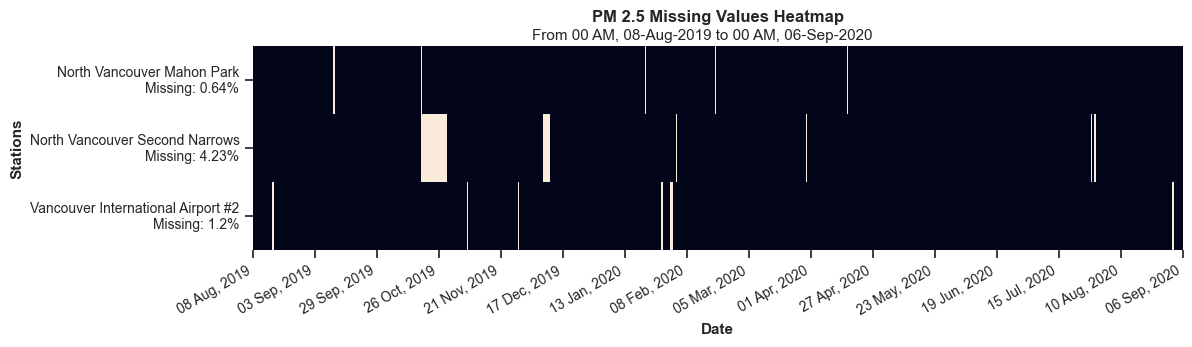

In [49]:
plot_missing(exp_covariate)

In [50]:
exp_covariate.fillna(method='ffill', inplace=True)

In [51]:
exp_subset_series = TimeSeries.from_dataframe(exp_subset)
exp_covariate_series = TimeSeries.from_dataframe(exp_covariate)

In [107]:
validation_cutoff = pd.Timestamp("2020-05-01")

train, val = exp_subset_series.split_after(validation_cutoff)

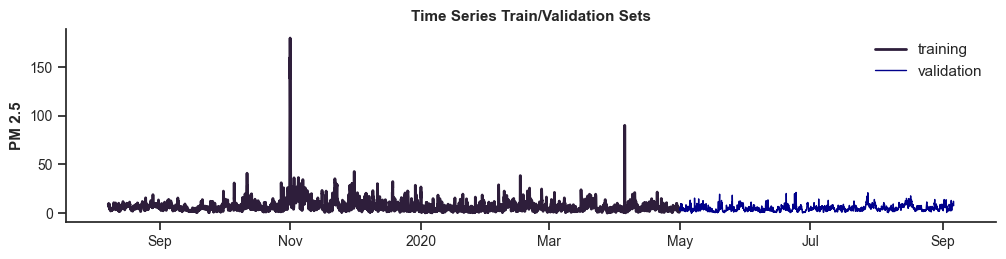

In [108]:
dart_plot(train, val)

In [54]:
max_lag = 48
step = 6

[-i for i in range(step, max_lag+step, step)]

[-6, -12, -18, -24, -30, -36, -42, -48]

#### Models Exploration

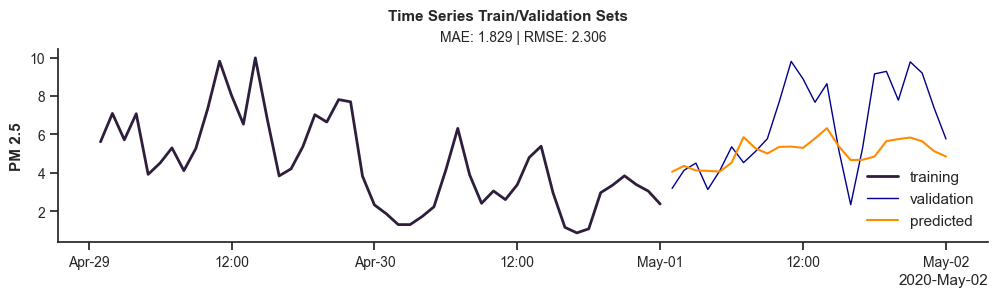

In [55]:
max_lag = 48
step = 6

lags = [-i for i in range(step, max_lag+step, step)]

model = LinearRegressionModel(
    lags=lags,
    output_chunk_length=1,
)
model.fit(train)
pred = model.predict(24)
dart_plot(train[-48:], val[:24], pred=pred)

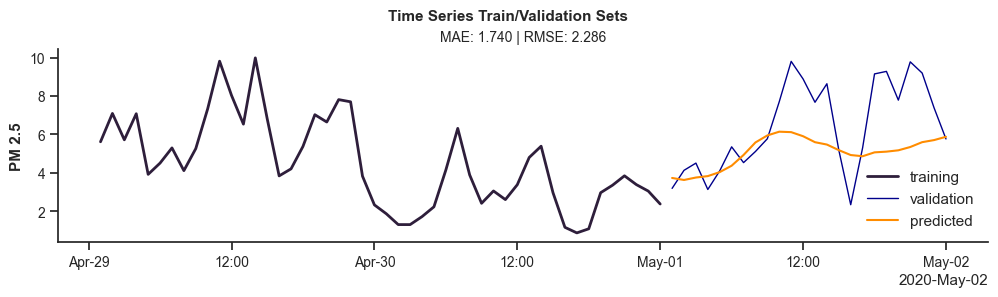

In [56]:
model = LinearRegressionModel(
    lags=lags,
    lags_past_covariates=lags,
    output_chunk_length=24,
)
model.fit(train, past_covariates=exp_covariate_series)
pred = model.predict(24)
dart_plot(train[-48:], val[:24], pred=pred)

In [57]:
from darts.models import XGBModel

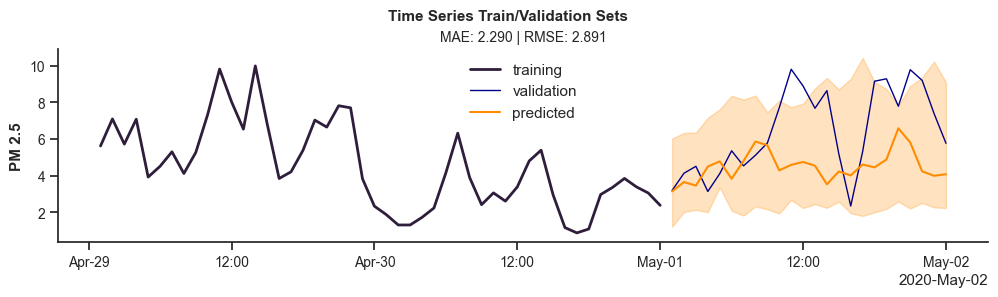

In [58]:
model = XGBModel(
    lags=lags,
    lags_past_covariates=lags,
    output_chunk_length=24,
    likelihood='quantile',
    quantiles=[0.05, 0.5, 0.95]
)
model.fit(train, past_covariates=exp_covariate_series)
pred = model.predict(n=24, num_samples=200)
dart_plot(train[-48:], val[:24], pred=pred)

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.


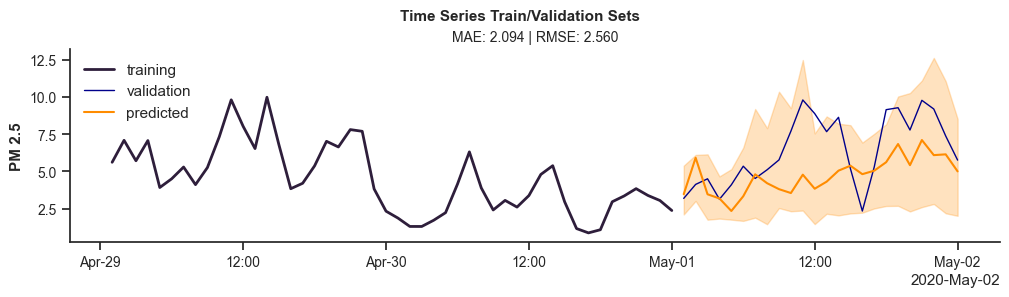

In [59]:
model = XGBModel(
    lags=lags,
    lags_past_covariates=lags,
    output_chunk_length=1,
    likelihood='quantile',
    quantiles=[0.05, 0.5, 0.95]
)
model.fit(train, past_covariates=exp_covariate_series)
pred = model.predict(n=24, num_samples=200)
dart_plot(train[-48:], val[:24], pred=pred)

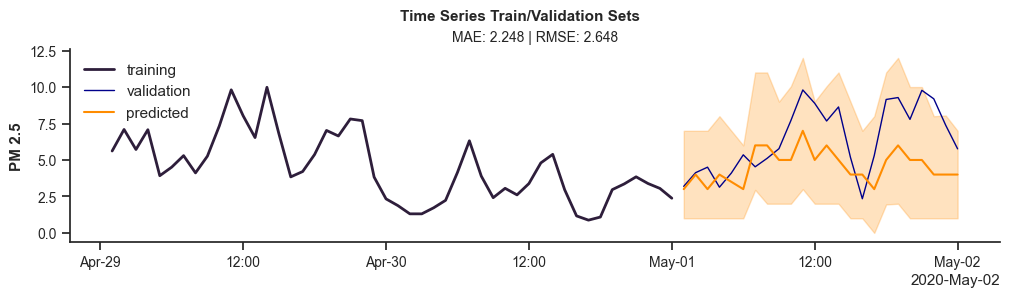

In [60]:
model = XGBModel(
    lags=lags,
    output_chunk_length=1,
    likelihood='poisson',
    random_state=123456
)
model.fit(train)
pred = model.predict(n=24, num_samples=200)
dart_plot(train[-48:], val[:24], pred=pred)

#### Model for missingness analysis

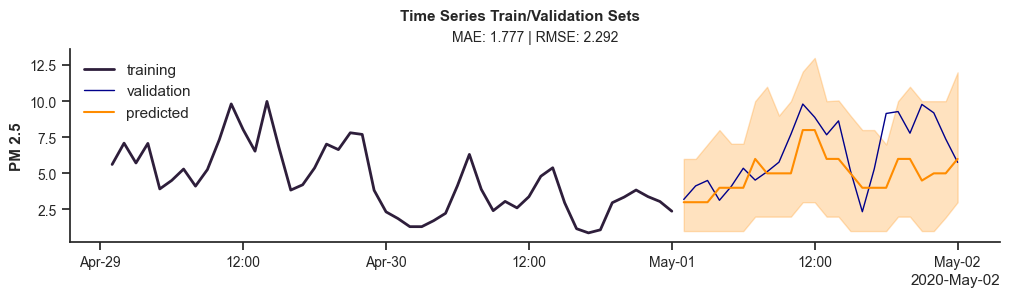

In [61]:
model = XGBModel(
    lags=lags,
    output_chunk_length=2,
    likelihood='poisson',
    random_state=123456
)
model.fit(train)
pred = model.predict(n=24, num_samples=200)
dart_plot(train[-48:], val[:24], pred=pred)

In [62]:
from darts.explainability import ShapExplainer

The model is probabilistic, but num_samples=1 will be used for explainability.


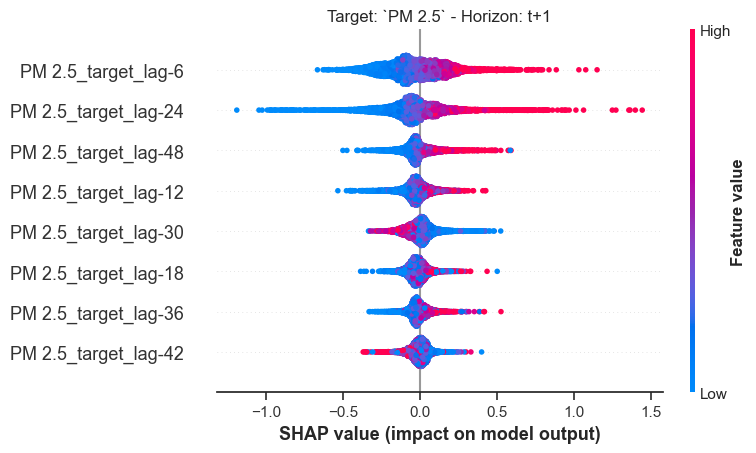

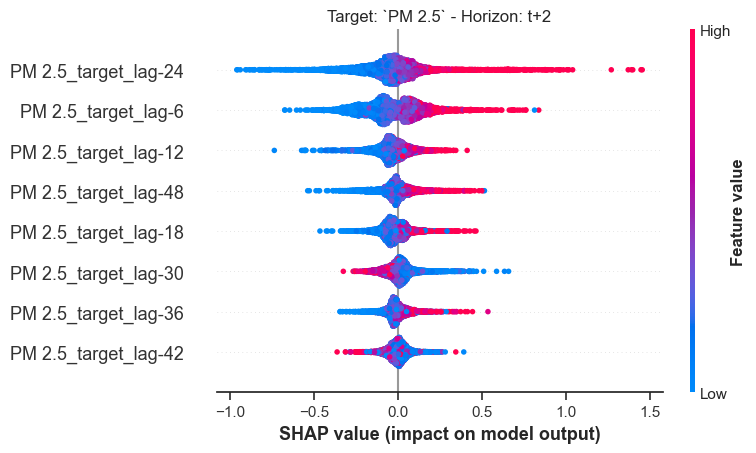

In [63]:
shap_explainer = ShapExplainer(model=model)
shap_values = shap_explainer.summary_plot()

In [64]:
from random import randrange
from datetime import timedelta

def random_date(start, end):
    """
    This function will return a random datetime between two datetime 
    objects.
    """
    delta = end - start
    int_delta = (delta.days * 24)
    random_hour = randrange(int_delta)
    return start + timedelta(hours=random_hour)

2020-08-05 18:00:00


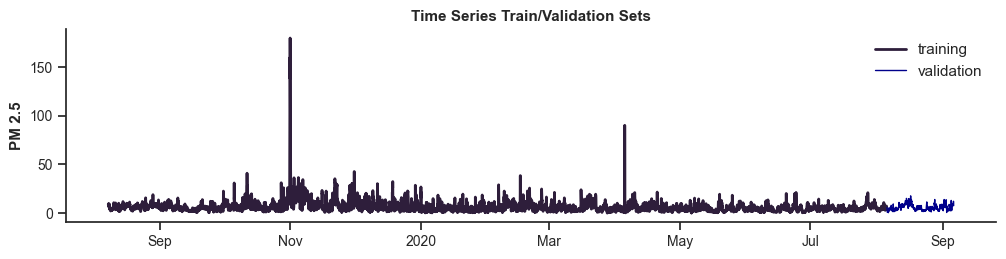

In [65]:
validation_cutoff = pd.Timestamp(random_date(datetime(2019, 8, 10), datetime(2020, 9, 5)))
print(validation_cutoff)

train, val = exp_subset_series.split_after(validation_cutoff)
dart_plot(train, val)

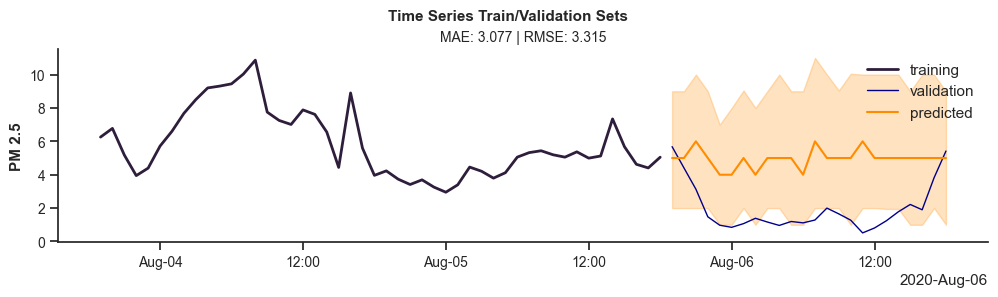

In [66]:
model = XGBModel(
    lags=lags,
    output_chunk_length=2,
    likelihood='poisson',
    random_state=123456
)
model.fit(train)
pred = model.predict(n=24, num_samples=200)
dart_plot(train[-48:], val[:24], pred=pred)

2020-06-27 19:00:00


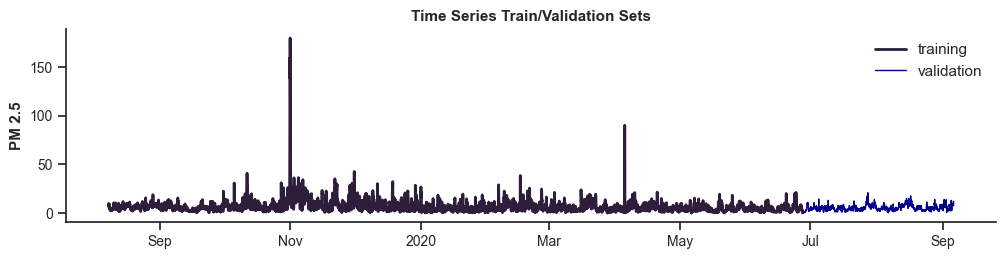

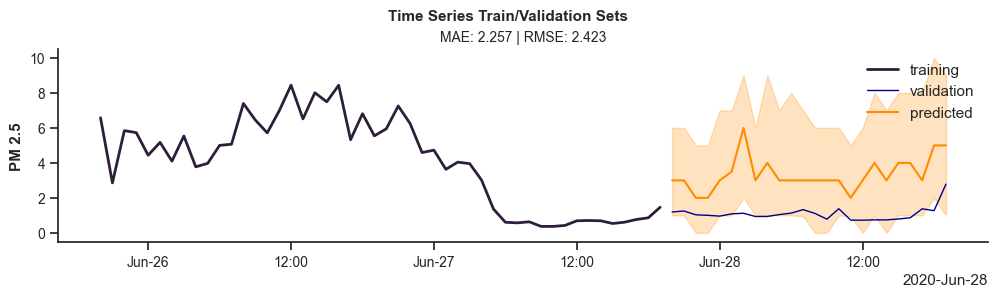

In [67]:
validation_cutoff = pd.Timestamp(random_date(datetime(2019, 8, 10), datetime(2020, 9, 5)))
print(validation_cutoff)

train, val = exp_subset_series.split_after(validation_cutoff)
dart_plot(train, val)

model = XGBModel(
    lags=lags,
    output_chunk_length=2,
    likelihood='poisson',
    random_state=123456
)
model.fit(train)
pred = model.predict(n=24, num_samples=200)
dart_plot(train[-48:], val[:24], pred=pred)

2020-06-18 04:00:00


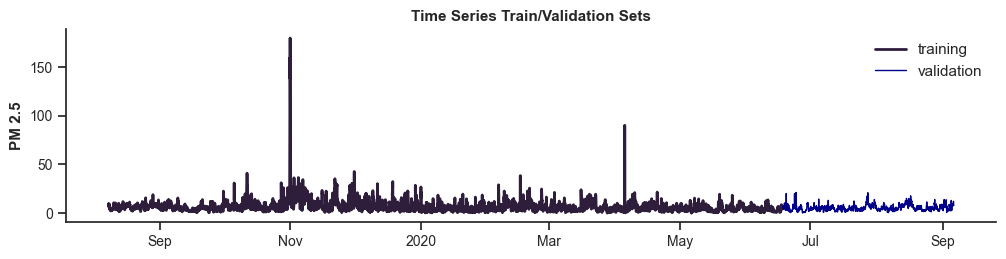

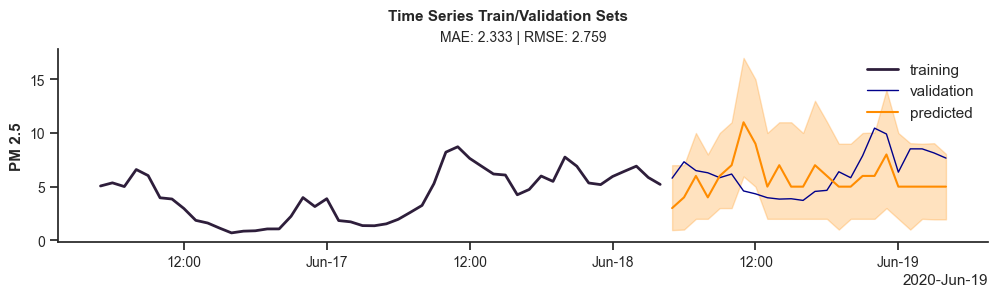

In [68]:
validation_cutoff = pd.Timestamp(random_date(datetime(2019, 8, 10), datetime(2020, 9, 5)))
print(validation_cutoff)

train, val = exp_subset_series.split_after(validation_cutoff)
dart_plot(train, val)

model = XGBModel(
    lags=lags,
    output_chunk_length=2,
    likelihood='poisson',
    random_state=123456
)
model.fit(train)
pred = model.predict(n=24, num_samples=200)
dart_plot(train[-48:], val[:24], pred=pred)

2019-12-16 05:00:00


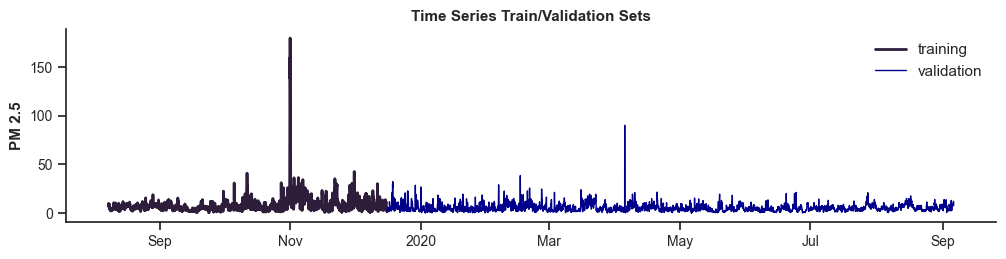

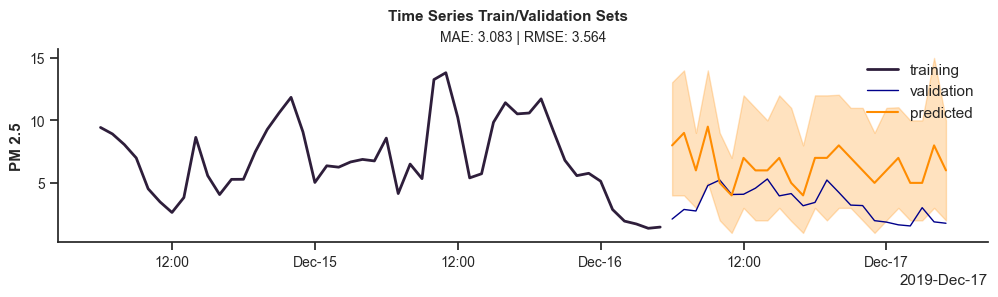

In [69]:
validation_cutoff = pd.Timestamp(random_date(datetime(2019, 8, 10), datetime(2020, 9, 5)))
print(validation_cutoff)

train, val = exp_subset_series.split_after(validation_cutoff)
dart_plot(train, val)

model = XGBModel(
    lags=lags,
    output_chunk_length=2,
    likelihood='poisson',
    random_state=123456
)
model.fit(train)
pred = model.predict(n=24, num_samples=200)
dart_plot(train[-48:], val[:24], pred=pred)

2020-02-27 00:00:00


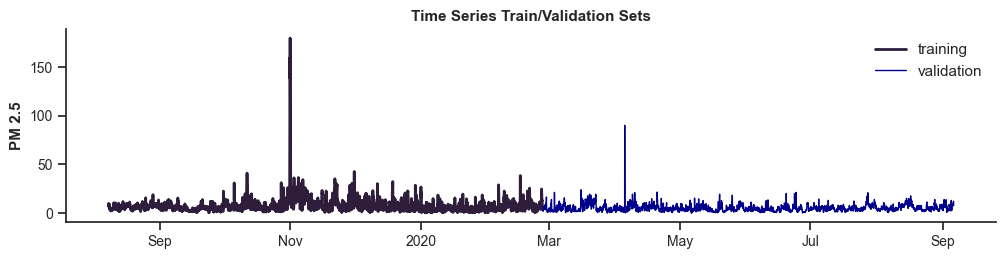

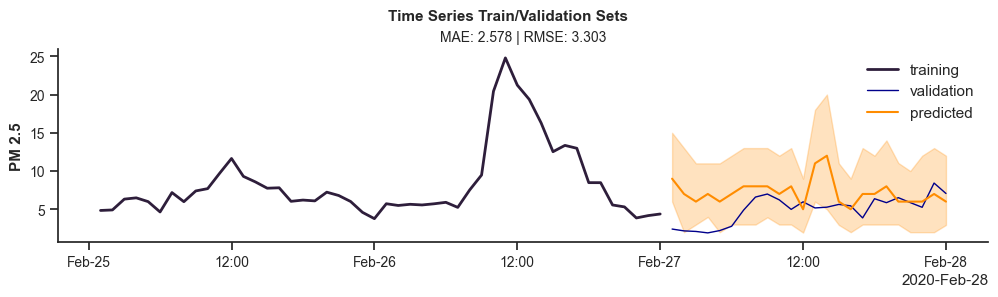

In [70]:
validation_cutoff = pd.Timestamp(random_date(datetime(2019, 8, 10), datetime(2020, 9, 5)))
print(validation_cutoff)

train, val = exp_subset_series.split_after(validation_cutoff)
dart_plot(train, val)

model = XGBModel(
    lags=lags,
    output_chunk_length=2,
    likelihood='poisson',
    random_state=123456
)
model.fit(train)
pred = model.predict(n=24, num_samples=200)
dart_plot(train[-48:], val[:24], pred=pred)

2020-02-27 00:00:00


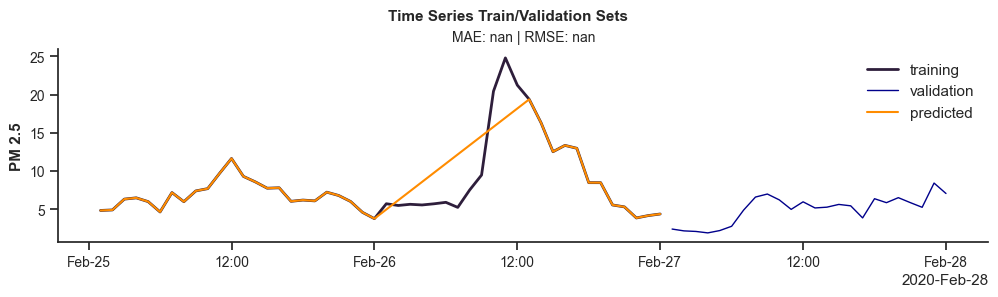

In [138]:
validation_cutoff = pd.Timestamp("2020-02-27 00:00:00")
# validation_cutoff = pd.Timestamp(random_date(datetime(2019, 8, 10), datetime(2020, 9, 5)))
print(validation_cutoff)

train = exp_subset[:validation_cutoff]
val = exp_subset[validation_cutoff + timedelta(0, 3600):]

_, train_missing = create_missing(
        data=train,
        value="PM 2.5",
        missing_length=12,
        padding=12,
        missing_index="end",
)

# Linear interpolation
train_linear = train_missing.copy()
train_linear["PM 2.5"] = (
        train_missing["PM 2.5"].interpolate(method="linear").tolist()
)

# Converting to Dart TimeSeries
train = TimeSeries.from_dataframe(train)
train_missing = TimeSeries.from_dataframe(train_missing)
train_linear = TimeSeries.from_dataframe(train_linear)
val = TimeSeries.from_dataframe(val)


dart_plot(train[-48:], val[:24], pred=train_linear[-48:])

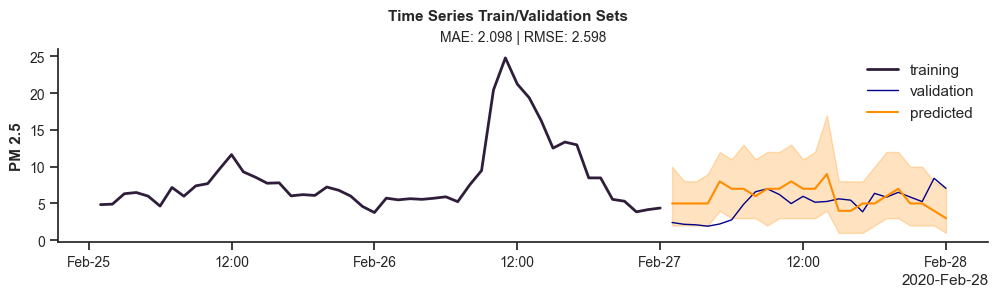

In [139]:
model = XGBModel(
    lags=lags,
    output_chunk_length=2,
    likelihood='poisson',
    random_state=123456
)
model.fit(train_linear)
pred = model.predict(n=24, num_samples=200)
dart_plot(train[-48:], val[:24], pred=pred)

In [165]:
'''
A probabilistic series will have shape (n_timesteps, n_target_variables, n_samples)
In our example we are outputing 200 samples of a 24h prediction window, of a single variable PM 2.5.
'''

pred.all_values().shape

(24, 1, 200)

In [337]:
rs = np.random.RandomState(1979)
x = rs.randn(500)
g = np.tile(list("ABCDEFGHIJ"), 50)
df = pd.DataFrame(dict(x=x, g=g))
m = df.g.map(ord)
df["x"] += m
df

,x,g
0,64.038123,A
1,66.147050,B
2,66.370011,C
3,68.791019,D
4,70.583534,E
...,...,...
495,69.358022,F
496,72.212877,G
497,70.474247,H
498,73.251022,I


In [417]:
pred_df = pd.DataFrame(pred.all_values()[:, 0, :]).T
pred_df = pred_df.melt(value_vars=pred_df.columns)

# Validation values
val_df = pd.DataFrame(np.broadcast_to(val[:24].all_values(), (24, 1, 200))[:, 0, :]).T
val_df = val_df.melt(value_vars=val_df.columns)
pred_df['PM 2.5 True Value'] = val_df['value']

# Renaming variables and time step identifier
pred_df['variable'] = pred_df['variable'].apply(lambda x: f't{x}')
pred_df.rename(columns={'variable': 'Time Step', 'value': 'PM 2.5 Prediction'}, inplace=True)
pred_df

,Time Step,PM 2.5 Prediction,PM 2.5 True Value
0,t0,6.0,2.410261
1,t0,5.0,2.410261
2,t0,2.0,2.410261
3,t0,0.0,2.410261
4,t0,4.0,2.410261
...,...,...,...
4795,t23,2.0,7.061769
4796,t23,3.0,7.061769
4797,t23,3.0,7.061769
4798,t23,3.0,7.061769


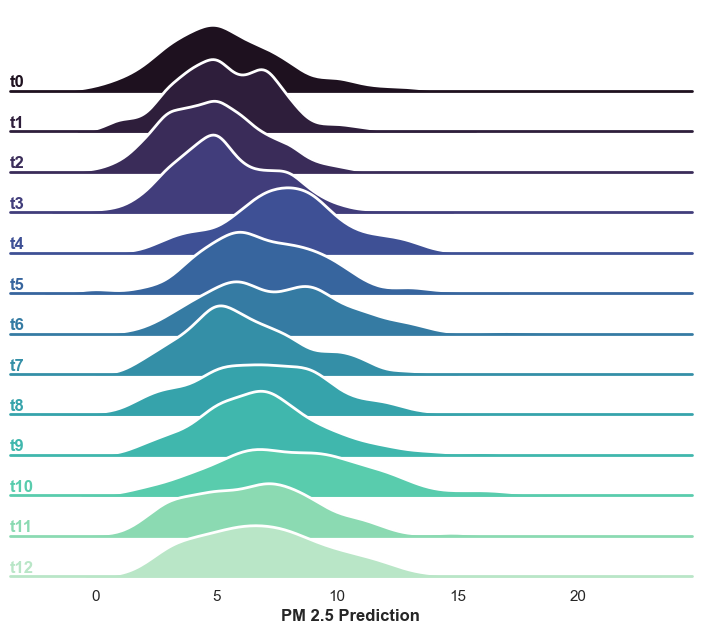

In [474]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# g = sns.FacetGrid(pred_df[pred_df['Time Step'].isin(['t0', 't1', 't2', 't3'])], row='Time Step', hue='Time Step', aspect=8, height=1, palette='mako')
# g = sns.FacetGrid(pred_df, row='Time Step', hue='Time Step', aspect=15, height=0.75, palette='mako')
g = sns.FacetGrid(pred_df[pred_df['Time Step'].isin([f't{i}' for i in range(0, 13)])],
                  row='Time Step', hue='Time Step', aspect=15, height=0.5, palette='mako')
g.map(sns.kdeplot, 'PM 2.5 Prediction', bw_adjust=0.8, clip_on=False, fill=True, alpha=1, linewidth=1)
g.map(sns.kdeplot, 'PM 2.5 Prediction', clip_on=False, color='w', lw=2, bw_adjust=0.8)
g.map(sns.pointplot, 'PM 2.5 True Value', color='orange')

g.refline(y=0, linewidth=2, linestyle='-', color=None, clip_on=False)

def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .1, label, fontweight='bold', color=color, ha='left', va='center', transform=ax.transAxes)

g.map(label, 'PM 2.5 Prediction')

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=0)
# g.figure.subplots_adjust(vspace=-0.1)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
# g.set(ylabel="")
g.despine(bottom=True, left=True)
# g.despine()

plt.show()

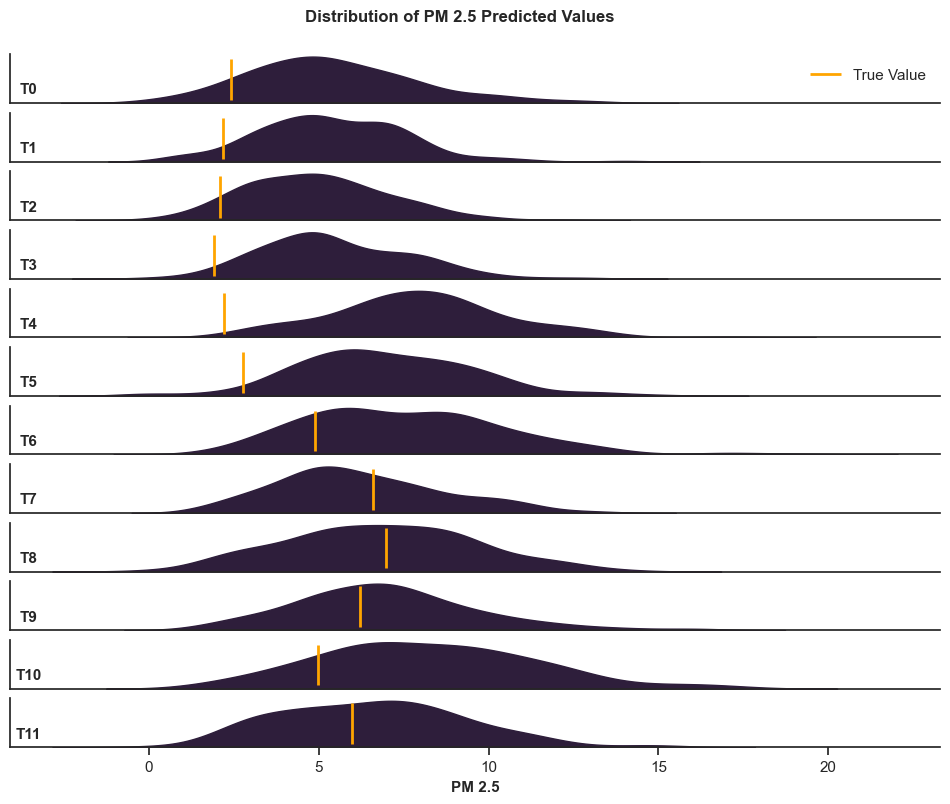

In [536]:
def plot_pi_distribution(pred, val, steps=6):
    fig, axes = plt.subplots(steps, 1, figsize=(12, 9), sharex=True)
    fig.suptitle('Distribution of PM 2.5 Predicted Values', y=0.93, fontsize=12, fontweight='bold')

    # pred_values = {}
    for step in range(steps):
        # pred_values[step] = pred.all_values()[step, 0, :].tolist()
        sns.kdeplot(pred.all_values()[step, 0, :].tolist(), ax=axes[step], fill=True, alpha=1)
        axes[step].vlines(val.values()[step][0], 0.01, 0.9*axes[step].get_ylim()[1], colors='orange', label='True Value', linewidth=2)
        axes[step].set_title(f'T{step}', x=0.02, y=0.02, fontsize=11, fontweight='bold')
        axes[step].set(yticks=[], ylabel="")
        axes[step].tick_params(bottom=False)
    axes[0].legend()
    axes[-1].set_xlabel('PM 2.5', fontsize=11, fontweight='bold')
    axes[-1].tick_params(bottom=True)
    sns.despine()
    plt.show()

plot_pi_distribution(pred, val[:24], steps=12)

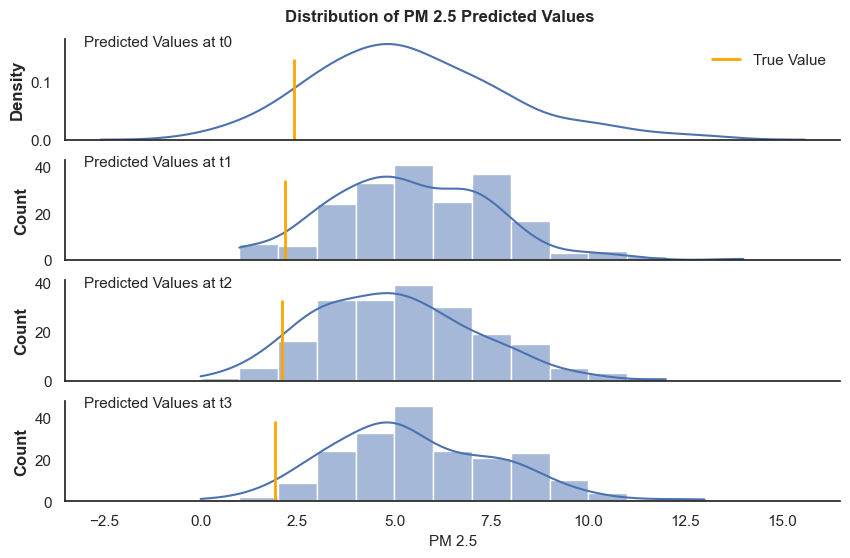

In [450]:
'''
You can observe the distribution of the 200 samples for each prediction step.
'''
pred_values_t0 = pred.all_values()[0, 0, :].tolist()
pred_values_t1 = pred.all_values()[1, 0, :].tolist()
pred_values_t2 = pred.all_values()[2, 0, :].tolist()
pred_values_t3 = pred.all_values()[3, 0, :].tolist()

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 6), sharex=True)
fig.suptitle('Distribution of PM 2.5 Predicted Values', y=0.93, fontsize=12, fontweight='bold')
sns.kdeplot(pred_values_t0, ax=ax1)
# sns.histplot(pred_values_t0, kde=True, ax=ax1)
# ax1.hist(pred_values_t0)
ax1.vlines(val.values()[0][0], 0, 0.8*ax1.get_ylim()[1], colors='orange', label='True Value', linewidth=2)
ax1.legend()
ax1.set_title('Predicted Values at t0', x=0.12, y=0.85, fontsize=11)

sns.histplot(pred_values_t1, kde=True, ax=ax2)
# ax2.hist(pred_values_t1)
ax2.vlines(val.values()[1][0], 0, 0.8*ax2.get_ylim()[1], colors='orange', label='True Value', linewidth=2)
# ax2.legend()
ax2.set_title('Predicted Values at t1', x=0.12, y=0.85, fontsize=11)

sns.histplot(pred_values_t2, kde=True, ax=ax3)
# ax3.hist(pred_values_t2)
ax3.vlines(val.values()[2][0], 0, 0.8*ax3.get_ylim()[1], colors='orange', label='True Value', linewidth=2)
# ax3.legend()
ax3.set_title('Predicted Values at t2', x=0.12, y=0.85, fontsize=11)

sns.histplot(pred_values_t3, kde=True, ax=ax4)
# ax4.hist(pred_values_t3)
ax4.vlines(val.values()[3][0], 0, 0.8*ax4.get_ylim()[1], colors='orange', label='True Value', linewidth=2)
# ax4.legend()
ax4.set_title('Predicted Values at t3', x=0.12, y=0.85, fontsize=11)
ax4.set_xlabel('PM 2.5', fontsize=11, fontweight='regular')

sns.despine()
plt.show()

In [192]:
'''
From our 200 samples we can observe the maximum and minimum point predictions.
'''
print(f'max: {pred.max(2).all_values().flatten()}')
print(f'min: {pred.min(2).all_values().flatten()}')

max: [13. 14. 12. 13. 17. 15. 19. 13. 14. 16. 17. 15. 21. 21. 15. 10. 12. 18.
 15. 15. 16. 18. 10. 10.]
min: [0. 1. 0. 0. 2. 0. 2. 2. 0. 2. 2. 0. 2. 2. 0. 0. 0. 1. 1. 1. 0. 1. 1. 0.]


In [264]:
'''
As well as our upper (95%) and lower (5%) quantiles.
'''
print(f'0.95 quantile: {pred.quantile_timeseries(0.95).all_values().flatten()}')
print(f'0.05 quantile: {pred.quantile_timeseries(0.05).all_values().flatten()}')

0.95 quantile: [10.    8.05  8.    9.   12.   11.   13.   11.   12.   12.   13.   11.
 12.   17.    8.05  8.    8.   10.   12.   12.   10.   10.    8.    7.  ]
0.05 quantile: [2. 2. 2. 2. 4. 3. 3. 3. 2. 3. 3. 3. 3. 4. 1. 1. 1. 2. 3. 3. 2. 2. 2. 1.]


In [260]:
'''
Which we can then use to evaluate our prediction interval against our validation set,
and determine the coverage of our prediction interval.
'''

def evaluate_prediction_interval(pred: TimeSeries,
                                 val: TimeSeries,
                                 lower_quantile: float=0.05,
                                 upper_quantile: float=0.95) -> np.ndarray:
    '''
    Evaluate Prediction Interval coverage of the true values of the validation set.
    '''
    assert pred.is_probabilistic, "Prediction series must be probabilistic."
    assert pred.n_timesteps == val.n_timesteps, "Prediciton and Validation series must be of same length."

    # Lower and Upper prediction interval series
    lower_bound = pred.quantile_timeseries(lower_quantile).all_values().flatten()
    upper_bound = pred.quantile_timeseries(upper_quantile).all_values().flatten()

    # Validation set
    val_flatten = val.all_values().flatten()

    # Accuracy vector
    accuracy_vector = np.logical_and(
        val_flatten >= lower_bound,
        val_flatten <= upper_bound
    )

    return accuracy_vector

In [533]:
evaluate_prediction_interval(pred, val[:24])

array([ True,  True,  True, False, False, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False, False])

In [116]:
paddings = [i for i in range(2, 48)]

In [ ]:
# Implementation example with cubic spline interpolation
for padding in paddings:
    subset, subset_missing = create_missing(
        data=station_subset,
        value="PM 2.5",
        start=datetime(2016, 6, 21),
        end=datetime(2016, 7, 1),
        missing_length=6,
        padding=padding,
        missing_index="end",
    )

    subset_spline = subset.copy()
    # Indexing missing values
    missing_idx = np.where(subset_missing["PM 2.5"].isna())[0].tolist()

    # Indexing boundary values at t-2, t-1, t+1, and t+2
    boundary_idx = []
    for idx in range(min(missing_idx)-2, max(missing_idx)+3):
        if idx not in missing_idx:
            boundary_idx.append(idx)
    boundary = subset_missing["PM 2.5"][boundary_idx].tolist()

    # Fitting cubic spline
    cubic_spline = interpolate.splrep(x=boundary_idx, y=boundary, k=3)
    imputed = interpolate.splev(missing_idx, cubic_spline)

    subset_spline["PM 2.5"][missing_idx] = imputed

    plot_compare(
        subset_spline,
        subset_missing,
        value="PM 2.5",
        value_missing="PM 2.5",
        missing_only=True,
        data_label="Cubic Spline interpolation",
        data_missing_label="Original data",
        plot_sup_title=f"MAE: {mae_score(subset, subset_spline, value='PM 2.5', verbose=False):.4f}\
 | RMSE: {rmse_score(subset, subset_spline, value='PM 2.5', verbose=False):.4f}",
        figsize=(15, 3)
    )